# <center>ML Project

<table bordercolor="white">
    <tr><td>
        <table style="background-color: #ffffff; filter: alpha(opacity=40); opacity: 0.95;border:1px blue solid;">
        <tr><td colspan=3 bgcolor='bbbbbb' style="text-align: center;">Submitters</td></tr>
        <tr><td><b>Student Name</b></td><td>
        <tr><td>Omri Shoham</td>
        <tr><td>Ido Levi</td>
         <tr><td><b>Group Num</b></td><td><b>32</b></td>
        </table>
  </tr>
</table>

## Required installations

In [259]:
%pip install missingno
%pip install openpyxl

You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Imports

In [260]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import plotly.express as px
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, auc, roc_auc_score, mean_squared_error, roc_curve,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import plot_tree
from scipy import stats, interp
from openpyxl.utils.cell import get_column_letter # see explanation where the func is being used

## Utility Functions

In [261]:
def replace_values (data: pd.DataFrame, columns, value_to_replace, replaced_value):
    '''
    columns: list of strings -> names of columns
    '''
    for col in columns:
        data[col] = data[col].replace({value_to_replace:replaced_value})
    return 

def find_zeros_and_replace (data, col_1, col_2):
    '''
    params: 2 columns that relates one to each other.
    example: num_of_admin_pages & admin_page_duration_min
    goal: if one of the columns valus is 0 and the other is nan, fill the nan with 0
    '''
    nans = data[col_1].isna()
    for i in range(len(nans)):
        if (nans[i] == True):
            if (data[col_2][i] == 0):
                data[col_1][i] = 0

    nans_1 = data[col_2].isna()
    for i in range(len(nans_1)):
        if (nans_1[i] == True):
            if (data[col_1][i] == 0):
                data[col_2][i] = 0
    return 

def barPerc(df, xVar, ax):
    '''
    barPerc(): Add percentage for hues to bar plots
    args:
        df: pandas dataframe
        xVar: (string) X variable 
        ax: Axes object (for Seaborn Countplot/Bar plot or
                         pandas bar plot)
    '''
    # 1. how many X categories
    ##   check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height()/total:.0%}', ha="center",va="bottom")
    return 

def remove_outlires(data, labels, outlier_dict):
    '''
    Removes columns that have outlier values. 
    These tresholds are defined in the dictionary we defined. 
    In addition, this function deletes the relevant lines from the label column. 
    '''
    labels_mask = np.ones((data.shape[0], ), dtype = int)
    
    for item in outlier_dict.items():
        mask_item = data[item[0]] > item[1]
        data = data.loc[(data[item[0]] <= item[1])]
        labels_mask = labels_mask - mask_item
    if labels is None:
        return data    
    labels_mask = labels_mask.apply(lambda x: True if x==1 else False)
    labels = labels[labels_mask]

    return data, labels

def remove_outlires_for_test_processing(data, outlier_dict):
    '''
    Removes columns that have outlier values. 
    These tresholds are defined in the dictionary we defined. 
    Here we DO NOT have labels, so no need to remove related values in label column 
    '''
    for item in outlier_dict.items():
        data = data.loc[(data[item[0]] <= item[1])]
    return data

def remove_outlier_iqr(df_in, col_name):
    '''
    # this func repalces the outliers to np.nan
    # outliers -> lower than 'min' or greater than 'max'
    '''
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

def adjust_col_A(column):
    column = column.apply(lambda x: x[2:])
    column = column.str.replace(',', '').astype(float).round().astype(int) # replaces all the '0' to max() + 1 
    column = column.apply(lambda x: column.max() + 1 if x==0 else x)
    return column

def remove_records_with_many_nans (data, threshold):
    rows_with_many_nans = data.isna().sum(axis = 1) > threshold
    many_nans_row_idx = data[rows_with_many_nans].index
    many_nans_row_idx = many_nans_row_idx.tolist()
    data.drop(many_nans_row_idx, axis=0, inplace=True) #dropping those columns
    return data

def remove_records_with_many_nans_VAL (data, labels, threshold):
    rows_with_many_nans = data.isna().sum(axis = 1) > threshold
    many_nans_row_idx = data[rows_with_many_nans].index
    many_nans_row_idx = many_nans_row_idx.tolist()
    data.drop(many_nans_row_idx, axis=0, inplace=True) #dropping those columns
    labels.drop(many_nans_row_idx, axis=0, inplace=True)
    return data, labels

def get_most_frequent_value_for_each_col_dict(data):
    '''
    returns a dict with the columns as keys and most frequent value as values.
    '''
    columns_list = data.columns.tolist()
    frequent_dict = {}
    for col in columns_list:
        frequent_dict[col] = data[col].mode()[0]
    return frequent_dict

def fill_nan_with_most_frequent_value(train_data,test_data):
    frequent_dict = get_most_frequent_value_for_each_col_dict(train_data)
    test_data_cols_list = test_data.columns.tolist()
    for col in test_data_cols_list:
        if col in test_data_cols_list:
            test_data[col] = test_data[col].fillna(frequent_dict[col])
    return

def dilute_features(data,num_of_features_to_remain_with):
    '''
    leave the only X features with the highest correlation to the label
    '''
    corr_to_purchase = data.corr()["purchase"].abs().sort_values(ascending = False)[1:]
    diluted_features = corr_to_purchase[:num_of_features_to_remain_with].index.to_list()
    return diluted_features

def run_model(model, parameters, train_data, validation_data, train_labels, validation_labels):
    classifier = model
    clf = GridSearchCV(classifier, parameters, scoring='roc_auc')
    clf.fit(train_data, train_labels)
    best_params = clf.best_params_
    best_score = clf.best_score_
    print (f'Model : {model}')
    print(f'Best Params: {best_params} \n')  
    # ROC
    fpr, tpr, thresholds = metrics.roc_curve(validation_labels, clf.predict_proba(validation_data)[:,1])
    val_auc = auc(fpr, tpr)
    #Plot
    plt.figure(figsize = (5,5))
    plt.title(f'ROC for {model}')
    plt.plot(fpr, tpr, color = 'red', label = 'AUC = %0.5f' % val_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #confusion matrix
    # Train data
    pred_train = clf.predict(train_data)         
    M_train = confusion_matrix(train_labels, pred_train)
    tp, fp, fn, tn = M_train.ravel() 
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_confusion_matrix(clf, train_data, train_labels, ax=ax)
    plt.grid(False)
    plt.title('Train data')
    plt.show()

    accuracies_t = cross_val_score(estimator = classifier, X = train_data, y = train_labels, cv = 10) 
    #Validation data
    pred_val = clf.predict(validation_data)
    M_val = confusion_matrix(validation_labels, pred_val)
    tp, fp, fn, tn = M_val.ravel()
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_confusion_matrix(clf, validation_data, validation_labels,ax=ax)
    plt.grid(False)
    plt.title('Validation data')
    plt.show()

    accuracies_v = cross_val_score(estimator = classifier, X = validation_data, y = validation_labels, cv = 10)
    print(f'Train AUC: {best_score}')
    print("K-fold Cross Validation TRAIN Accuracy Mean: {:.2f} %".format(accuracies_t.mean()*100))
    print(f"Train accuracy: {round(accuracy_score(train_labels, pred_train)*100, 2)} %")
    print("Train Standard Deviation: {:.2f} %".format(accuracies_t.std()*100))   
    print("Train Mse: {:.2f} %\n".format(mean_squared_error(train_labels, pred_train)*100))
    print (f"Validation AUC: {val_auc}")
    print("K-fold Cross Validation VALIDATION Accuracy Mean: {:.2f} %".format(accuracies_v.mean()*100))
    print(f"Val accuracy: {round(accuracy_score(validation_labels, pred_val)*100, 2)} %")
    print("Val Standard Deviation: {:.2f} %".format(accuracies_v.std()*100))
    print("Val Mse: {:.2f} %\n".format(mean_squared_error(validation_labels, pred_val)*100))
    
    return

def run_FINAL_model(model_with_best_parameters, train_data, train_labels, test_data):
    clf = model_with_best_parameters
    clf.fit(train_data, train_labels)
    pred = clf.predict_proba(test_data)
    pred = pd.DataFrame(pred[:,1], test_data['id'])
    pred.rename(columns = {0: 'predict_prob'}, inplace = True)
    return pred

def Pipeline(train_data, test_data, final_best_features: list):
    #train data
    replace_values(train_data, ["total_duration"], 0, np.nan)
    train_data['info_page_duration'] = train_data['info_page_duration'].str.replace('minutes', '')
    train_data['product_page_duration'] = train_data['product_page_duration'].str.replace('minutes', '')
    train_data = train_data.astype({'product_page_duration' : float}, errors='raise')
    train_data = train_data.astype({'info_page_duration' : float}, errors='raise')
    train_data.rename(columns = {'admin_page_duration': 'admin_page_duration_min','info_page_duration': 'info_page_duration_min', 'product_page_duration': 'product_page_duration_min',\
                                                        'total_duration': 'total_duration_min'}, inplace = True)
    replace_values(train_data, ["info_page_duration_min", "product_page_duration_min"], 0, np.nan)
    find_zeros_and_replace(train_data, 'admin_page_duration_min', 'num_of_admin_pages')
    find_zeros_and_replace(train_data, 'info_page_duration_min', 'num_of_info_pages')
    find_zeros_and_replace(train_data, 'product_page_duration_min', 'num_of_product_pages')
    train_data = remove_records_with_many_nans(train_data, 5) # removing rows with many nans func
    y_train = train_data.iloc[:,-1]
    train_data.drop(['D'],axis=1,inplace=True)
    for col in columns_list:
        train_data[col].fillna(value = train_data[col].mean(axis = 0, skipna = True), inplace = True)
    replace_values(train_data, ['info_page_duration_min'], np.nan, 0)
    train_data['closeness_to_holiday'].fillna(value = train_data.closeness_to_holiday.mean(axis = 0, skipna = True), inplace=True)
    most_frequent_val_col_device = train_data.device.value_counts().index[0]
    most_frequent_val_col_A = train_data.A.value_counts().index[0]
    train_data = train_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
    train_data.A = adjust_col_A(train_data.A)
    train_data.internet_browser = train_data.internet_browser.apply(lambda x: 'edge' if x[0]=='e' else x)
    train_data.internet_browser = train_data.internet_browser.apply(lambda x: 'chrome' if x[0]=='c' else x)
    train_data.internet_browser = train_data.internet_browser.apply(lambda x: 'safari' if x[0]=='s' else x)
    train_data.internet_browser = train_data.internet_browser.apply(lambda x: x[:10] if x[0]=='b' else x)
    train_data['Season'] = train_data['Month'].apply(lambda x: season_dict[x]) # insert the new column
    train_data,y_train = remove_outlires(train_data, y_train, outlier_val_dict)
    train_data[columns_to_normalize] = mmscaler.fit_transform(train_data[columns_to_normalize]) 
    train_data['internet_browser'] = train_data['internet_browser'].apply(lambda x: x.rstrip('_')) 
    train_data['C'] = train_data['C'].apply(lambda x: x.replace('_','')) 
    train_data['Region'] = train_data['Region'].apply(lambda x: 'Region_' + str(x))
    train_data['Region'] = train_data['Region'].apply(lambda x: x[:-2]) 
    train_data['device'] = train_data['device'].apply(lambda x: int(x)) #it's string of numbers, convert it to int
    train_data['device'] = train_data['device'].apply(lambda x: 'device_' + get_column_letter(x))
    train_data['Weekend'] = train_data['Weekend'].apply(lambda x: 1 if x == True else 0)    
    #test data
    replace_values(test_data, ["total_duration"], 0, np.nan)
    test_data['info_page_duration'] = test_data['info_page_duration'].str.replace('minutes', '')
    test_data['product_page_duration'] = test_data['product_page_duration'].str.replace('minutes', '')
    test_data = test_data.astype({'product_page_duration' : float}, errors='raise')
    test_data = test_data.astype({'info_page_duration' : float}, errors='raise')
    test_data.rename(columns = {'admin_page_duration': 'admin_page_duration_min','info_page_duration': 'info_page_duration_min',\
                'product_page_duration': 'product_page_duration_min', 'total_duration': 'total_duration_min'}, inplace = True)
    replace_values(test_data, ["info_page_duration_min", "product_page_duration_min"], 0, np.nan)
    find_zeros_and_replace(test_data, 'admin_page_duration_min', 'num_of_admin_pages')
    find_zeros_and_replace(test_data, 'info_page_duration_min', 'num_of_info_pages')
    find_zeros_and_replace(test_data, 'product_page_duration_min', 'num_of_product_pages')
    test_data.drop(['D'],axis=1,inplace=True)
    for col in columns_list: 
        test_data[col].fillna(value = train_data[col].mean(axis = 0, skipna = True), inplace = True)
    replace_values(test_data, ['info_page_duration_min'], np.nan, 0)
    test_data['closeness_to_holiday'].fillna(value = train_data.closeness_to_holiday.mean(axis = 0, skipna = True), inplace=True)
    test_data['device'] = test_data['device'].replace(np.nan, most_frequent_val_col_device) 
    test_data['A'].replace(np.nan, most_frequent_val_col_A, inplace = True)
    fill_nan_with_most_frequent_value(train_data, test_data)
    test_data.internet_browser = test_data.internet_browser.apply(lambda x: 'edge' if x[0]=='e' else x)
    test_data.internet_browser = test_data.internet_browser.apply(lambda x: 'chrome' if x[0]=='c' else x)
    test_data.internet_browser = test_data.internet_browser.apply(lambda x: 'safari' if x[0]=='s' else x)
    test_data.internet_browser = test_data.internet_browser.apply(lambda x: x[:10] if x[0]=='b' else x)
    test_data['Season'] = test_data['Month'].apply(lambda x: season_dict[x]) # insert the new column
    test_data['A'] = adjust_col_A(test_data['A'])
    test_data[columns_to_normalize] = mmscaler.fit_transform(test_data[columns_to_normalize])
    test_data['internet_browser'] = test_data['internet_browser'].apply(lambda x: x.rstrip('_')) 
    test_data['C'] = test_data['C'].apply(lambda x: x.replace('_','')) 
    test_data['device'] = test_data['device'].apply(lambda x: int(x) if x != np.nan else x) #it's string of numbers, convert it to int
    test_data['device'] = test_data['device'].apply(lambda x: 'device_' + get_column_letter(x))
    test_data['Region'] = test_data['Region'].apply(lambda x: 'Region_' + str(x))
    test_data['Region'] = test_data['Region'].apply(lambda x: x[:-2])     
    test_data['Weekend'] = test_data['Weekend'].apply(lambda x: 1 if x == True else 0)
  
    train_data = pd.get_dummies(train_data, prefix='dummy', columns = catagorical_features, drop_first= True) 
    test_data = pd.get_dummies(test_data, prefix='dummy', columns = catagorical_features, drop_first= True)
    train_data = train_data[final_best_features]
    test_data = test_data[final_best_features]

    return run_FINAL_model(RandomForestClassifier(n_estimators = 194 ,max_depth= 11, criterion = 'entropy', min_samples_leaf = 3,
                                    min_samples_split = 2, random_state = 0), train_data, y_train, test_data)

def plot_KFold(model_with_best_parameters_for_kfold, X, y, K):
    clf = model_with_best_parameters_for_kfold
    cv = StratifiedKFold(n_splits = K, shuffle=False)
    # plot arrows
    fig1 = plt.figure(figsize=[12,10])
    ax1 = fig1.add_subplot(111,aspect = 'equal')
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    for train,test in cv.split(X, y):
        # print(train)
        # print(test)
        # break
        prediction = clf.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        fpr, tpr, t = roc_curve(np.array(y)[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
            label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

# Data exploration

### Loading The Train Data

In [262]:
train_df = pd.read_csv('train.csv')

In [263]:
train_df.shape

(10479, 23)

In [264]:
train_df.describe()

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,num_of_product_pages,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,device,Region,B,D,purchase
count,10479.00000,9874.000000,10066.000000,9792.000000,10076.000000,5726.000000,10457.000000,10453.000000,10452.000000,9983.000000,10156.000000,10460.000000,10456.000000,105.000000,10479.000000
mean,5239.00000,2.321957,80.462468,0.502655,31.870187,1302.457216,0.021854,0.042859,5.900387,0.061985,2.122981,3.155641,99.769628,4.060440,0.154690
std,3025.17107,3.335331,179.217548,1.265812,44.816259,2039.312905,0.048100,0.048297,18.727496,0.199429,0.906859,2.404672,10.050268,2.189818,0.361626
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,60.733919,-1.235571,0.000000
25%,2619.50000,0.000000,0.000000,0.000000,7.000000,221.000000,0.000000,0.014283,0.000000,0.000000,2.000000,1.000000,93.030568,3.141657,0.000000
50%,5239.00000,1.000000,8.000000,0.000000,18.000000,677.851191,0.002968,0.025161,0.000000,0.000000,2.000000,3.000000,99.787249,4.432221,0.000000
75%,7858.50000,4.000000,93.000000,0.000000,38.000000,1605.733333,0.016667,0.050000,0.000000,0.000000,3.000000,4.000000,106.506626,5.531061,0.000000
max,10478.00000,27.000000,3398.750000,24.000000,705.000000,47850.920680,0.200000,0.200000,361.763742,1.000000,8.000000,9.000000,141.735142,7.618254,1.000000


In [265]:
num_of_purchases_sessions = (train_df['purchase'] == 1).sum()
print(f'The mean of purchase is: {round(num_of_purchases_sessions / train_df.shape[0] * 100, 2)} %')

The mean of purchase is: 15.47 %


let's check out the type of every column

In [266]:
train_df.dtypes

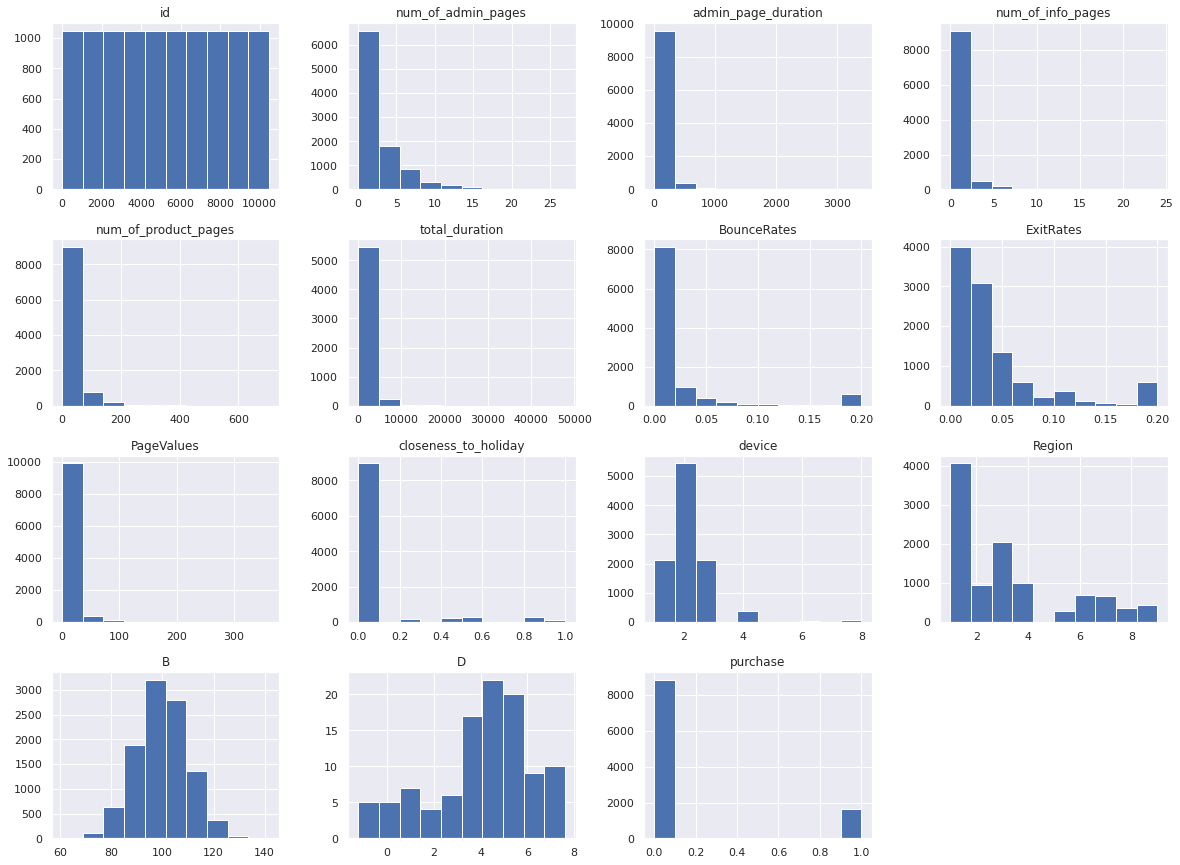

In [267]:
train_df.hist(figsize= (20,15))
plt.show()

Do more sessions ends with purchase?

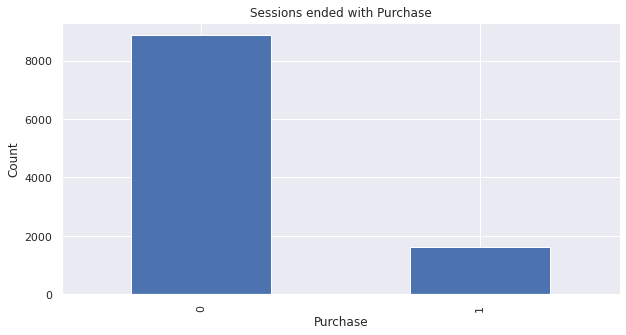

In [268]:
plt.figure(figsize=(10, 5))
train_df['purchase'].value_counts().plot(kind = 'bar')
plt.xlabel('Purchase') 
plt.ylabel('Count') 
plt.title('Sessions ended with Purchase')
plt.show()

### Quick review from what we have discover so far

1. We have 22 features, 8 of them are ```object``` type, and the rest of them are numerical (```float```/```int```).
2. Some of the ```duration``` columns are object type (textual, for example: "0.0 minutes"), while other are numerical. 
3. There are 10,479 records in train data. 
4. We expected the columns of ```Region``` and ```device``` to be textual, rather than numerical as they are. 
5. There are some features with many missing values. 
6. The percentage of sessions that end in a purchase is 15.47 %

We will address those insights later. 
   

Let's discoer how many missing values there are in every featur

In [269]:
train_df.isna().sum()

The barplot provides a simple plot where each bar represents a column within the dataframe. 

The height of the bar indicates how complete that column is - how many non-null values are present.

It can be generated by calling upon:
In this graph we can see that a number of the columns (```total_duration```, ```D```) have a large amount of missing values.

Other columns (such as ```BounceRate```, ```ExitRate```) are complete and have the maximum number of values.


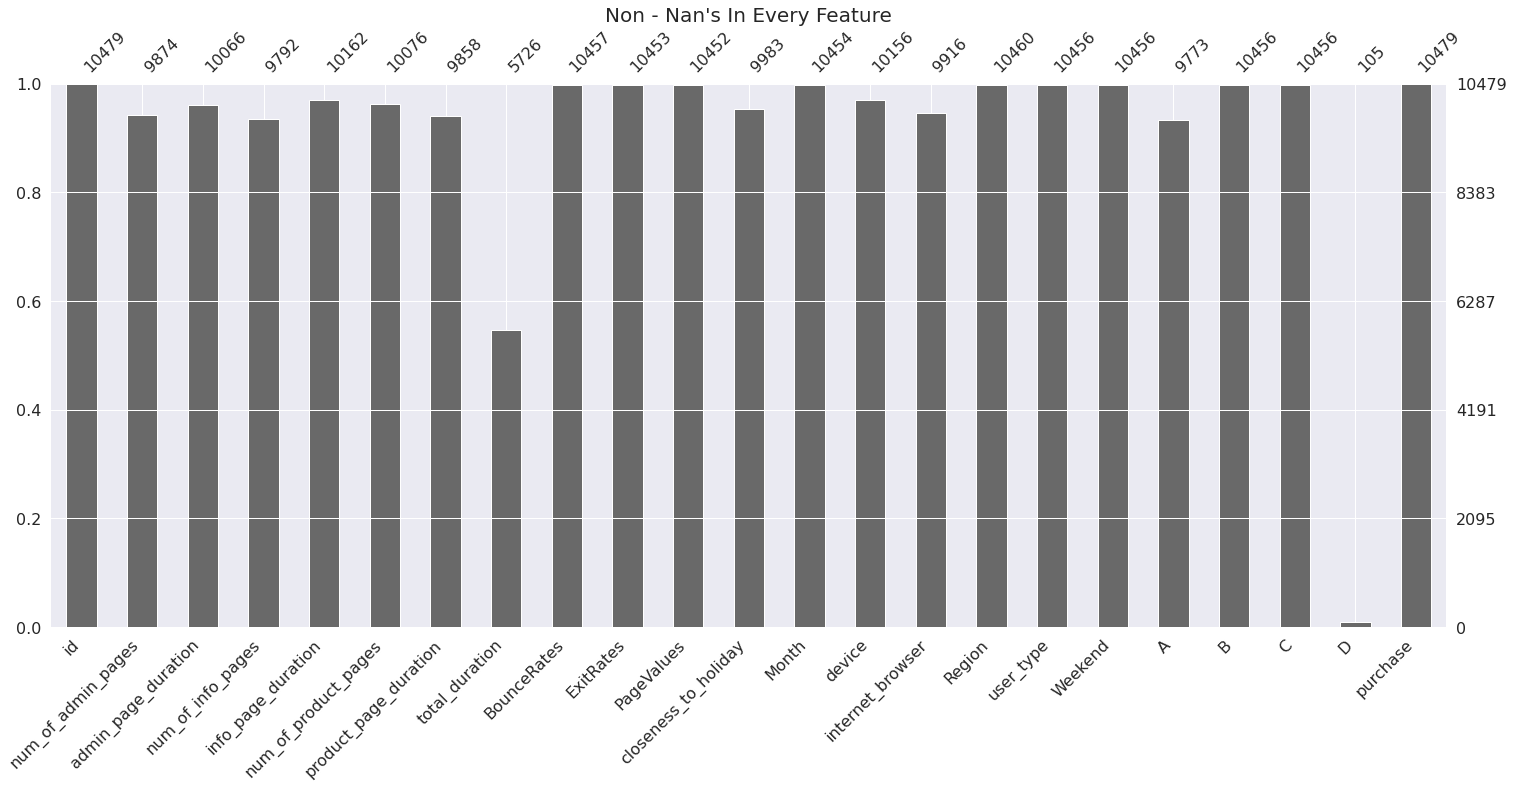

In [270]:
msno.bar(train_df)
plt.title("Non - Nan's In Every Feature", fontdict={'fontsize':20})
plt.show()

The heatmap is used to identify correlations of the nullity between each of the different columns. 

In other words, it can be used to identify if there is a relationship in the presence of null values between each of the columns.

We can see that `ExitRates` and `PageValue` has the highest correlation which stands on 0.6%. 

This figure can teach us that there is a relationship between the percentage of departures of the site from a particular page and the amount of pages worth money visited by the user. The reference to pages that are worth money is for pages that have potential for purchase, for example - a user settings page is not worth money.

`ExitRates` - Google Analytics measure for percentage of users who left the site from 
a specific page.

`PageValue`- Google Analytics measure. Page Value is the average value for a page 
that a user visited before landing on the goal page or completing an 
Ecommerce transaction (or both).

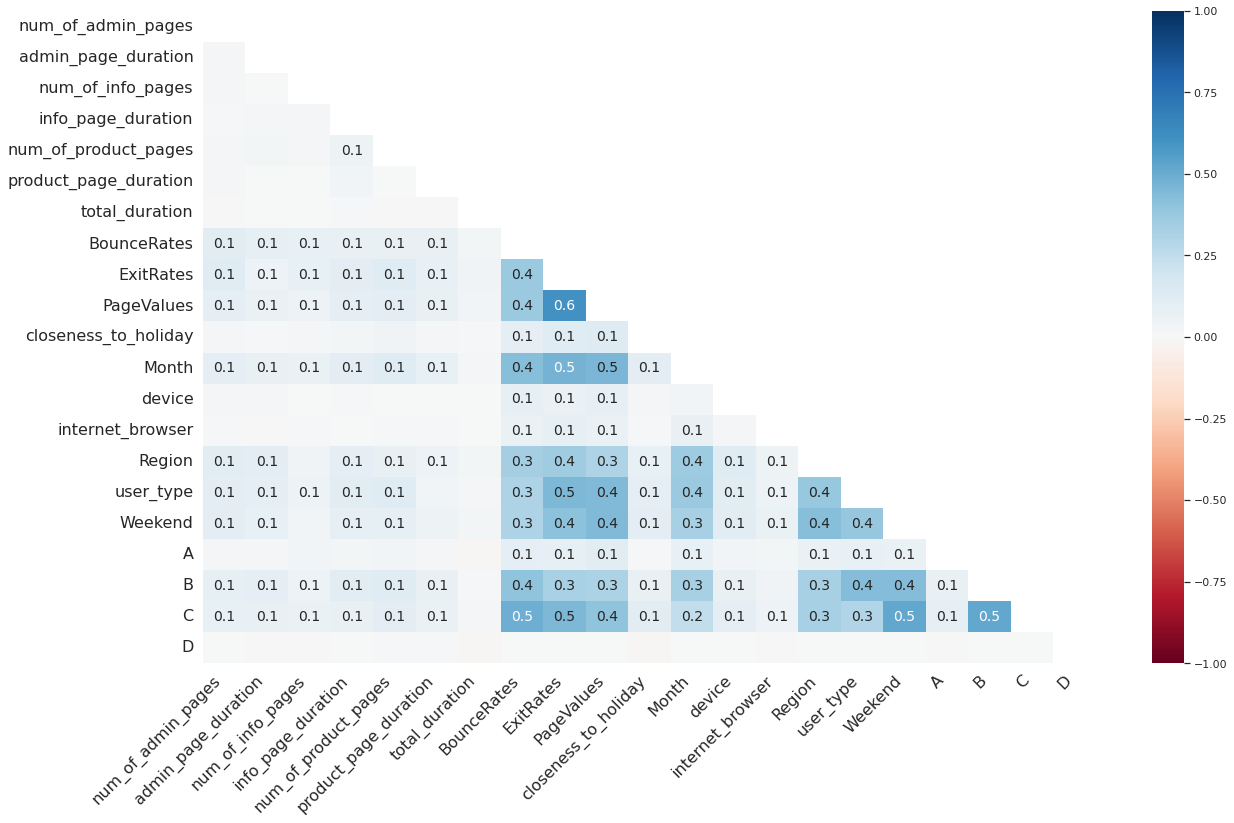

In [271]:
msno.heatmap(train_df)
plt.show()

Let's see how the ```total_duration``` distributes

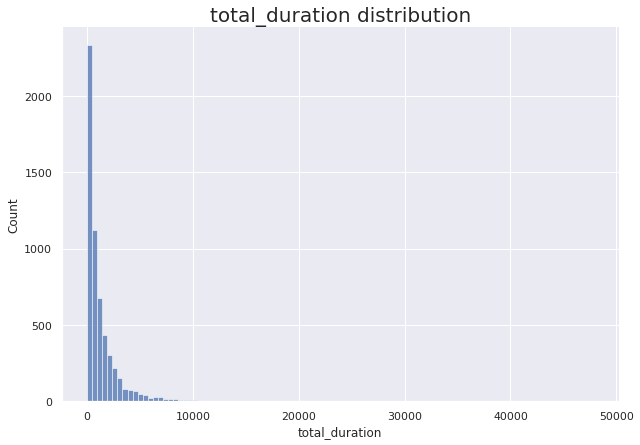

In [272]:
sns.displot(train_df, x=train_df["total_duration"], bins=100, height=6, aspect=1.5)
sns.set(font_scale = 1.2)
plt.title('total_duration distribution',  fontdict = {'fontsize':20})
plt.show()

In [273]:
print(f'There are {(train_df["total_duration"] == 0).sum()} zeros in this column which affects the distribution and can be ignored')

There are 332 zeros in this column which affects the distribution and can be ignored


Replacing those zeros with```nan```values

In [274]:
replace_values(train_df, ["total_duration"], 0, np.nan)

As we can see, the majority of the ```total_durtion``` values are between 0 to 12,000. let's zoom in a little..(after ignoring zeros)

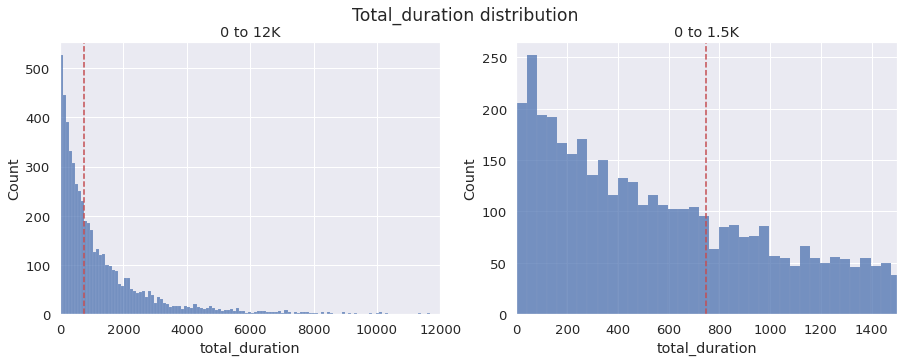

In [275]:
fig, axs = plt.subplots(nrows = 1, ncols = 2 ,figsize = (15,5))
axs = axs.ravel()

plt.subplot(1, 2, 1) 

fig.suptitle("Total_duration distribution")

k12 = sns.histplot(data=train_df, x=train_df["total_duration"], bins = 500)
k12.set(xlim =(0, 12000))
plt.title('0 to 12K')
plt.gca().axvline(train_df["total_duration"].median(), color='r', linestyle='--')

plt.subplot(1, 2, 2)
plt.title('0 to 1.5K')
second = sns.histplot(data=train_df, x=train_df["total_duration"], bins = 1200)
second.set(xlim =(0, 1500))

plt.gca().axvline(train_df["total_duration"].median(), color='r', linestyle='--')
plt.show()

The dashed red line represents the median of total_duration, a figure which helps us to learn more about this feature. Below may help us in favor of filling in gaps etc.

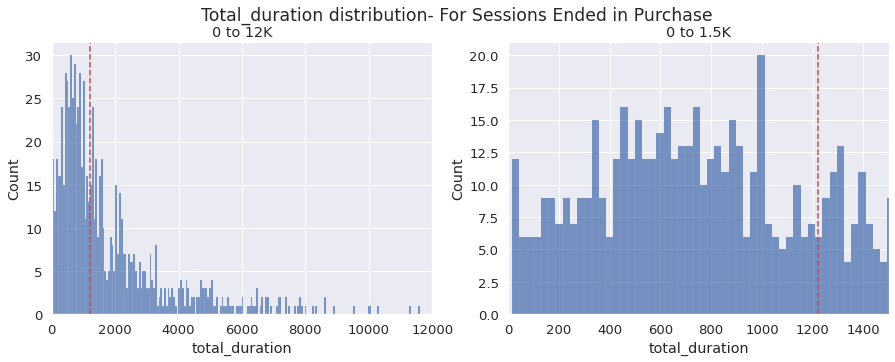

In [276]:
purchases_mask_df = train_df['purchase'] == 1
purchases_mask_df = train_df[purchases_mask_df]
fig, axs = plt.subplots(nrows = 1, ncols = 2 ,figsize = (15,5))
axs = axs.ravel()

plt.subplot(1, 2, 1) 

fig.suptitle("Total_duration distribution- For Sessions Ended in Purchase")
k12 = sns.histplot(data = purchases_mask_df, x = purchases_mask_df["total_duration"], bins = 500)
k12.set(xlim =(0, 12000))

plt.title('0 to 12K')
plt.gca().axvline(purchases_mask_df["total_duration"].median(), color='r', linestyle='--')

plt.subplot(1, 2, 2)
plt.title('0 to 1.5K')
second = sns.histplot(data = purchases_mask_df, x = purchases_mask_df["total_duration"], bins = 1000)
second.set(xlim =(0, 1500))

plt.gca().axvline(purchases_mask_df["total_duration"].median(), color='r', linestyle='--')
plt.show()

Most sessions that result in a purchase are between 300 and 900 total duration long.

We will first have to turn ```info_page_duration``` and ```product_page_duration``` into floating columns and replace ```minutes``` in each cell in order to examine the density of these columns. During this stage, we will also change the names of the 3 duration columns to include the unit of time

In [277]:
#erase the 'minutes' in those 2 columns + change the number from str to float
train_df['info_page_duration'] = train_df['info_page_duration'].str.replace('minutes', '')
train_df['product_page_duration'] = train_df['product_page_duration'].str.replace('minutes', '')

train_df = train_df.astype({'product_page_duration' : float}, errors='raise')
train_df = train_df.astype({'info_page_duration' : float}, errors='raise')

# add the unit of time to the columns names
train_df.rename(columns = {'admin_page_duration': 'admin_page_duration_min','info_page_duration': 'info_page_duration_min', 'product_page_duration': 'product_page_duration_min',\
                                                    'total_duration': 'total_duration_min'}, inplace = True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10479 entries, 0 to 10478
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10479 non-null  int64  
 1   num_of_admin_pages         9874 non-null   float64
 2   admin_page_duration_min    10066 non-null  float64
 3   num_of_info_pages          9792 non-null   float64
 4   info_page_duration_min     10162 non-null  float64
 5   num_of_product_pages       10076 non-null  float64
 6   product_page_duration_min  9858 non-null   float64
 7   total_duration_min         5394 non-null   float64
 8   BounceRates                10457 non-null  float64
 9   ExitRates                  10453 non-null  float64
 10  PageValues                 10452 non-null  float64
 11  closeness_to_holiday       9983 non-null   float64
 12  Month                      10454 non-null  object 
 13  device                     10156 non-null  flo

*Comment*
* We have added to the columns describing the durations of the time unit. 

  These columns are textual and in the fields a 'minute' appears and from this we understand that it is the unit of time. It is important to say that we think there is an error in the data and that the correct unit of time is seconds. 
  
  This is because it seems unlikely to us that a session will last over 1000 minutes (about 16 hours), and there are very many of them.

    However, this will not change the model because later in the work we will normalize all the data, so even if we now divide all 60 of these columns by 60, the normalized columns later will remain the same.

Replacing those zeros with ```nan``` values

In [278]:
replace_values(train_df, ["info_page_duration_min", "product_page_duration_min"], 0, np.nan)

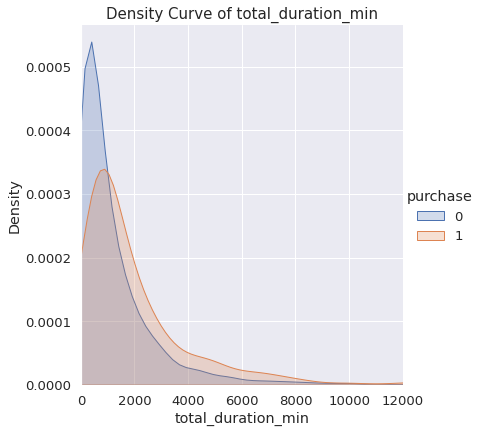

In [279]:
(sns.FacetGrid(train_df, hue="purchase", height = 6, xlim = (0,12000))
    .map(sns.kdeplot, 'total_duration_min', shade = True)
    .add_legend());
plt.title("Density Curve of total_duration_min", fontdict = {'fontsize':15})
plt.show()

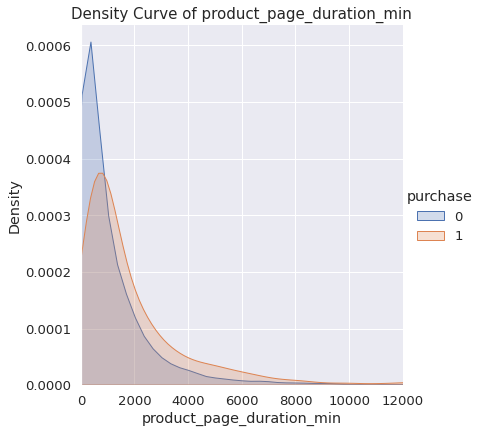

In [280]:
(sns.FacetGrid(train_df, hue="purchase", height = 6, xlim = (0,12000))
    .map(sns.kdeplot, 'admin_page_duration_min', shade = True)
    .add_legend());
plt.title("Density Curve of admin_page_duration", fontdict = {'fontsize':15})

(sns.FacetGrid(train_df, hue="purchase", height = 6, xlim = (0,12000))
    .map(sns.kdeplot, 'info_page_duration_min', shade = True)
    .add_legend());
plt.title("Density Curve of info_page_duration_min", fontdict = {'fontsize':15})

(sns.FacetGrid(train_df, hue="purchase", height = 6, xlim = (0,12000))
    .map(sns.kdeplot, 'product_page_duration_min', shade = True)
    .add_legend());
plt.title("Density Curve of product_page_duration_min", fontdict = {'fontsize':15})
plt.show()

We can see that the `product_page_duration_min` feature spreads over a larger range of duration values. 

### Correlations between features
(for only numerical variables)

In [281]:
correlations = train_df.corr()
train_df.corr()

,id,num_of_admin_pages,admin_page_duration_min,num_of_info_pages,info_page_duration_min,num_of_product_pages,product_page_duration_min,total_duration_min,BounceRates,ExitRates,PageValues,closeness_to_holiday,device,Region,B,D,purchase
id,1.000000,0.082526,0.044857,0.066631,0.039301,0.173407,0.148520,0.150358,-0.054239,-0.077429,0.053881,-0.225908,0.043127,0.010513,-0.016671,-0.129515,0.124522
num_of_admin_pages,0.082526,1.000000,0.591505,0.383974,0.136288,0.436619,0.356473,0.432176,-0.222772,-0.317713,0.102648,-0.099734,-0.010604,-0.007737,-0.016465,-0.197337,0.145048
admin_page_duration_min,0.044857,0.591505,1.000000,0.297256,0.203517,0.291797,0.361779,0.435526,-0.141197,-0.202072,0.068009,-0.072091,-0.011671,-0.003730,-0.018782,-0.110871,0.097504
num_of_info_pages,0.066631,0.383974,0.297256,1.000000,0.461899,0.382615,0.390644,0.483267,-0.116471,-0.165944,0.046150,-0.051921,-0.011148,-0.032790,-0.021416,-0.167875,0.095563
info_page_duration_min,0.039301,0.136288,0.203517,0.461899,1.000000,0.179011,0.298083,0.337940,-0.009131,-0.017793,-0.004857,-0.034211,-0.023037,-0.053915,-0.032163,-0.226549,0.040175
num_of_product_pages,0.173407,0.436619,0.291797,0.382615,0.179011,1.000000,0.857099,0.874656,-0.202365,-0.292254,0.057020,-0.027799,0.000877,-0.043437,-0.019066,-0.326672,0.157167
product_page_duration_min,0.148520,0.356473,0.361779,0.390644,0.298083,0.857099,1.000000,0.994292,-0.106900,-0.213798,0.039076,-0.041957,0.003090,-0.035668,-0.022647,-0.304360,0.140213
total_duration_min,0.150358,0.432176,0.435526,0.483267,0.337940,0.874656,0.994292,1.000000,-0.121388,-0.233768,0.042578,-0.048698,-0.007831,-0.046853,-0.026140,-0.227477,0.131781
BounceRates,-0.054239,-0.222772,-0.141197,-0.116471,-0.009131,-0.202365,-0.106900,-0.121388,1.000000,0.911589,-0.116746,0.081161,0.024877,-0.008510,0.008744,0.147855,-0.150683
ExitRates,-0.077429,-0.317713,-0.202072,-0.165944,-0.017793,-0.292254,-0.213798,-0.233768,0.911589,1.000000,-0.172314,0.111041,0.015076,-0.009308,0.007393,0.231711,-0.207804


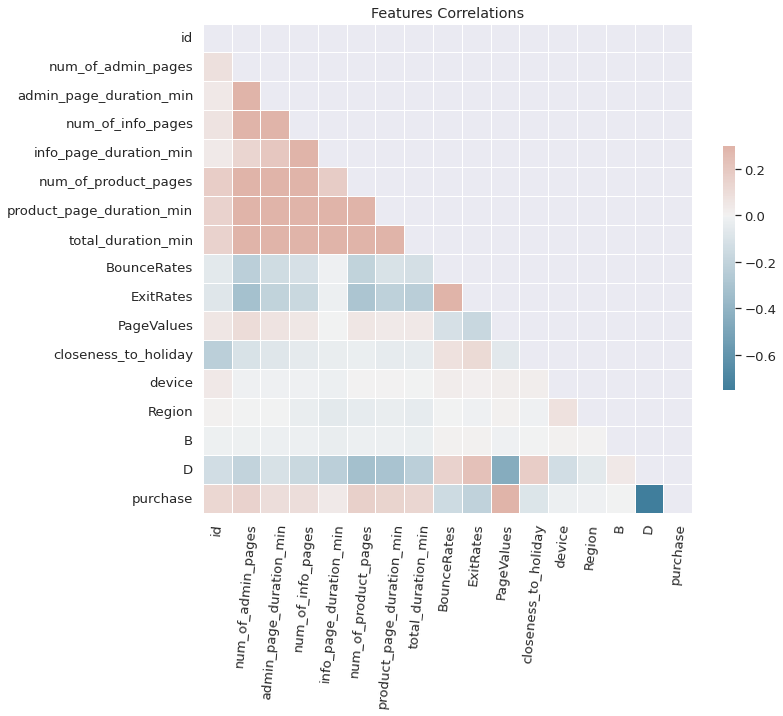

In [282]:
corr = train_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Features Correlations')
plt.xticks(rotation = 85)
plt.show()

Graphs such as this one allow us to see the correlation between variables.
Once this is identified, we can use it to reduce the dimensions, if two features tell us the same story, we don't need them both.

Dimentionality reduction will be addressed later in this project.

In [283]:
#Strongest 10 correlations
strong_corr = correlations.abs().unstack()
strong_corr[strong_corr != 1].sort_values(kind="quicksort", ascending= False).head(10)

*Correlations we found*

1. Correlation between ```PageValue``` and ```Purchase```. As well as correlation between ```ExitRate``` and ```BounceRate```.
2. Correlation between ```D``` and ```Purchase```.
3. No correlation between ```num_of_product_pages``` and ```Device```. 

Examine the strongest correlation we have (between ```BounceRates``` and ```ExitRates```)

In [284]:
fig = px.scatter(train_df, x='total_duration_min', y="product_page_duration_min", trendline="ols", \
                 trendline_color_override="red", title = 'The Strongest Correlation')
fig.show()

### Distribution of Purchases by Month
1. We can see that 2 months are missing - January and April, in those months there were no sessions, or just this is a situation of missing data.
2. Easy to see that November is the month were the purchase rate is the highest.

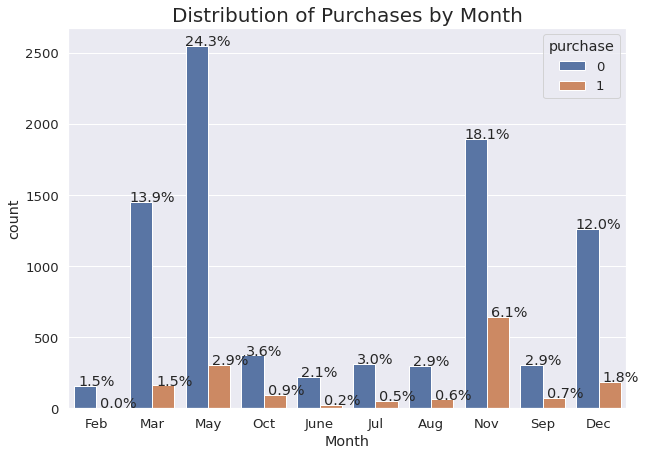

In [285]:
plt.figure(figsize = (10,7))
plt.title("Distribution of Purchases by Month", fontdict = {'fontsize':20})
ax = sns.countplot(x = "Month", hue = 'purchase', data = train_df)
total = float(len(train_df))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

Let's look at each month individually

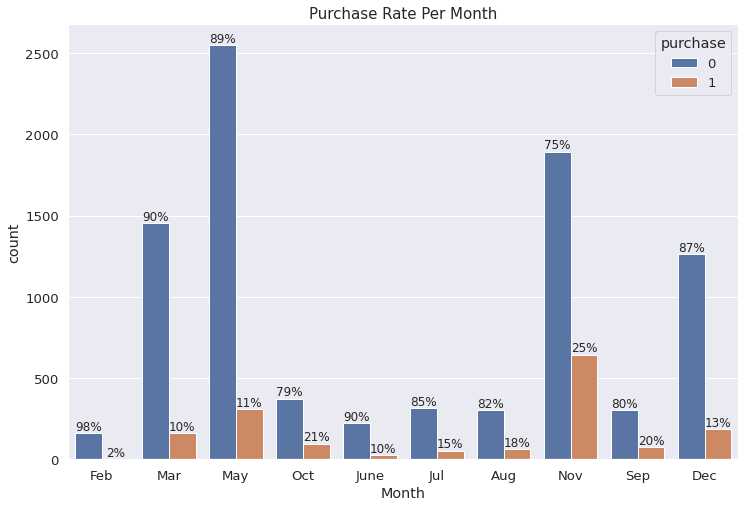

In [286]:
ax = sns.countplot(x = "Month", hue = 'purchase', data = train_df)
sns.set(rc = {'figure.figsize':(10,7)})
barPerc(train_df, 'Month', ax)
plt.title('Purchase Rate Per Month',fontdict = {'fontsize':15})
plt.show()

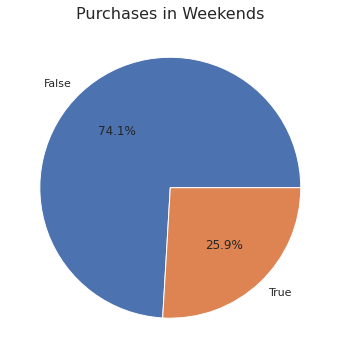

In [287]:
purchase_mask = train_df.purchase == 1
train_df.groupby('Weekend').size().plot.pie(subplots=True,autopct='%1.1f%%', figsize=(11, 6))
plt.title("Sessions in Weekends", fontdict= {'fontsize':16})
plt.ylabel("")
plt.show()
train_df[purchase_mask].groupby('Weekend').size().plot.pie(subplots=True,autopct='%1.1f%%', figsize=(11, 6))
plt.title("Purchases in Weekends", fontdict= {'fontsize':16})
plt.ylabel("")
plt.show()

In [288]:
weekend_prec_in_week = ((2/7)*100)

print(f'We expected to get at least: {round(((2/7)*100), 2)} % of session in weekends, which demonstrate the amount of days in weekend (2) out of 7 days a week, it is interesting to see that this precentage is actually lower')

We expected to get at least: 28.57 % of session in weekends, which demonstrate the amount of days in weekend (2) out of 7 days a week, it is interesting to see that this precentage is actually lower


# Preprocecing 

## Filling Missing Values

In [289]:
train_df.isna().sum()

Drop the```D```column since the majority values of it are nan's

In [290]:
train_df.drop(['D'],axis=1,inplace=True)
features_num = train_df.shape[1] - 1
print(f' Now we have {features_num} features (not inluding the labels)') # -1 because 1 column is the label

 Now we have 21 features (not inluding the labels)


Now we will take care of missing values in the duration columns, we saw at the section that there is high positive correlation between the number of pages to the duration of the related pages.

Filling missing valus in the 3 pairs of columns we have, Using the `find_zeros_and_replace` func we wrote, see documentation in the 'functions' section.
1. **```num_of_admin_pages``` & ```admin_page_duration_min```**
2. **`num_of_info_pages` & `info_page_duration_min`**
3. **`num_of_info_pages` & `info_page_duration_min`**

**```num_of_admin_pages``` & ```admin_page_duration_min```**

In [291]:
admin_p_num_nans = train_df['num_of_admin_pages'].isna().sum()
admin_p_dur_nans = train_df['admin_page_duration_min'].isna().sum()

print(f'Current number of nan in num_of_admin_pages column is: {admin_p_num_nans}')
print(f'Current number of nan in admin_page_duration_mi column is: {admin_p_dur_nans}')
print('now use the func..')

find_zeros_and_replace(train_df, 'admin_page_duration_min', 'num_of_admin_pages')

admin_p_num_nans = train_df['num_of_admin_pages'].isna().sum()
admin_p_dur_nans = train_df['admin_page_duration_min'].isna().sum()

print(f'Current number of nan in num_of_admin_pages column is: {admin_p_num_nans}')
print(f'Current number of nan in admin_page_duration_mi column is: {admin_p_dur_nans}')

Current number of nan in num_of_admin_pages column is: 605
Current number of nan in admin_page_duration_mi column is: 413
now use the func..
Current number of nan in num_of_admin_pages column is: 326
Current number of nan in admin_page_duration_mi column is: 229


**`num_of_info_pages` & `info_page_duration_min`**

In [292]:
info_p_num_nans = train_df['num_of_info_pages'].isna().sum()
info_p_dur_nans = train_df['info_page_duration_min'].isna().sum()

print(f'Current number of nan in num_of_info_pages column is: {info_p_num_nans}')
print(f'Current number of nan in info_page_duration_min column is: {info_p_dur_nans}')
print('now use the func..')

find_zeros_and_replace(train_df, 'info_page_duration_min', 'num_of_info_pages')

info_p_num_nans = train_df['num_of_admin_pages'].isna().sum()
info_p_dur_nans = train_df['info_page_duration_min'].isna().sum()

print(f'Current number of nan in num_of_info_pages column is: {info_p_num_nans}')
print(f'Current number of nan in info_page_duration_min column is: {info_p_dur_nans}')

Current number of nan in num_of_info_pages column is: 687
Current number of nan in info_page_duration_min column is: 8493
now use the func..
Current number of nan in num_of_info_pages column is: 326
Current number of nan in info_page_duration_min column is: 800


**`num_of_product_pages` & `product_page_duration_min`**

In [293]:
product_p_num_nans = train_df['num_of_product_pages'].isna().sum()
product_p_dur_nans = train_df['product_page_duration_min'].isna().sum()

print(f'Current number of nan in num_of_product_pages column is: {product_p_num_nans}')
print(f'Current number of nan in product_page_duration_min column is: {product_p_dur_nans}')
print('now use the func..')

find_zeros_and_replace(train_df, 'product_page_duration_min', 'num_of_product_pages')

product_p_num_nans = train_df['num_of_product_pages'].isna().sum()
product_p_dur_nans = train_df['product_page_duration_min'].isna().sum()

print(f'Current number of nan in num_of_product_pages column is: {product_p_num_nans}')
print(f'Current number of nan in product_page_duration_min column is: {product_p_dur_nans}')

Current number of nan in num_of_product_pages column is: 403
Current number of nan in product_page_duration_min column is: 1215
now use the func..
Current number of nan in num_of_product_pages column is: 403
Current number of nan in product_page_duration_min column is: 1184


Dropping records with a lot of missing values - We decided to set the threshold at 5.

In [294]:
train_df.shape[0]

10479

In [295]:
train_df = remove_records_with_many_nans(train_df, 5) # we deleted 54 records

In [296]:
train_df.shape[0]

10425

In [297]:
train_df.isna().sum() #We will now go and check how many missing values we have left and we will take care of them

Check if there is a nullity correlation, in order to determine if there is something behind those missing values. 

We have created a new data with 6 columns that have missing values, each column is Boolean. For a row that has a missing value we put the value 1, otherwise 0. We then checked the correlation between the columns in this new data.

In [298]:
train_df_check_nan_corr= train_df.copy()

A new bool column will be added where 0 means there is no missing value, 1 means there is nan in the corresponding record.

We will add this new column to each of those exsisting columns: 

1. num_of_admin_pages
2. admin_page_duration_min
3. num_of_info_pages
4. info_page_duration_min
5. num_of_product_pages
6. product_page_duration_min

In [299]:
train_df_check_nan_corr['num_of_admin_pages_nan'] = train_df_check_nan_corr[['num_of_admin_pages']].isna().sum(axis=1).apply(lambda x: 0 if x==0 else 1)
train_df_check_nan_corr['admin_page_duration_min_nan'] = train_df_check_nan_corr[['admin_page_duration_min']].isna().sum(axis=1).apply(lambda x: 0 if x==0 else 1)
train_df_check_nan_corr['num_of_info_pages_nan'] = train_df_check_nan_corr[['num_of_info_pages']].isna().sum(axis=1).apply(lambda x: 0 if x==0 else 1)
train_df_check_nan_corr['info_page_duration_min_nan'] = train_df_check_nan_corr[['info_page_duration_min']].isna().sum(axis=1).apply(lambda x: 0 if x==0 else 1)
train_df_check_nan_corr['num_of_product_pages_nan'] = train_df_check_nan_corr[['num_of_product_pages']].isna().sum(axis=1).apply(lambda x: 0 if x==0 else 1)
train_df_check_nan_corr['product_page_duration_min_nan'] = train_df_check_nan_corr[['product_page_duration_min']].isna().sum(axis=1).apply(lambda x: 0 if x==0 else 1)

In [300]:
train_df_check_nan_corr.shape

(10425, 28)

In [301]:
train_df_check_nan_corr.drop(train_df_check_nan_corr.columns[0:22], axis=1, inplace=True) # dropping the 'old' columns

In [302]:
train_df_check_nan_corr.shape

(10425, 6)

In [303]:
train_df_check_nan_corr.columns

Index(['num_of_admin_pages_nan', 'admin_page_duration_min_nan',
       'num_of_info_pages_nan', 'info_page_duration_min_nan',
       'num_of_product_pages_nan', 'product_page_duration_min_nan'],
      dtype='object')

Let's now check the correlations

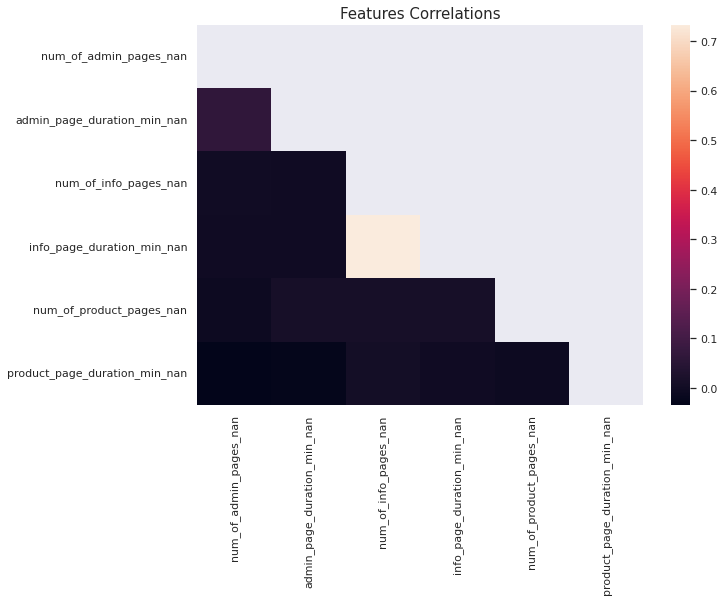

In [304]:
correlations = train_df_check_nan_corr.corr()
plt.title('Features Correlations', fontdict = {'fontsize':15})
mask_ut = np.triu(np.ones(correlations.shape)).astype(np.bool)
hmap = sns.heatmap(correlations, mask=mask_ut)
plt.show()

As we can see, there is no correlation between any of those new bollian columns, except for the `num_of_info_pages_nan` that has strong correlation to `info_page_duration_min_nan`.

We conclude that the missing values in the columns:

1. num_of_admin_pages
2. admin_page_duration_min
3. num_of_product_pages
4. product_page_duration_min

can be replaced with some mean / median / constant value, which will not cause a certain bias.

Filling missing values with the mean values

In [305]:
columns_list = ['num_of_admin_pages','admin_page_duration_min','num_of_product_pages','product_page_duration_min']
for col in columns_list:
    train_df[col].fillna(value = train_df[col].mean(axis = 0, skipna = True), inplace = True)


For the columns `num_of_info_pages` and `info_page_duration_min` we will replace the missing values with the nearest neighbore using KNN, instead of dropping those rows. 

**We decided to abandon this course of action as it caused us problems in later stages, see a concluding report for more details on this.**

In [306]:
# cur_df = pd.DataFrame()
# cur_df['num_of_info_pages'] = train_df['num_of_info_pages']
# cur_df['info_page_duration_min'] = train_df['info_page_duration_min']
# imputer = KNNImputer(n_neighbors = 2, weights = "uniform")
# cur_df_after = imputer.fit_transform(cur_df)
# classifier = KNeighborsClassifier(n_neighbors=2)
# classifier.fit(cur_df, y_train)
# y_pred = classifier.predict(cur_df)
# train_df.drop(['num_of_info_pages', 'info_page_duration_min'], axis = 1, inplace = True) 
# train_df.insert(3, "num_of_info_pages",cur_df_after[:,0], allow_duplicates=True)
# train_df.insert(4, "info_page_duration_min",cur_df_after[:,1], allow_duplicates=True)
# train_df.iloc[:,1:7].isna().sum() # now we have 0 nan's in those columns

let's fill the missing values in 'info_page_duration_min' feature

In [307]:
train_df['info_page_duration_min'].value_counts()

The vast majority of the values for this feature are zeros, so it was decided that the missing values would be replaced with zeros (the most frequent value).

In [308]:
replace_values(train_df, ['info_page_duration_min'], np.nan, 0)

In [309]:
train_df['info_page_duration_min'].isna().sum() # now we do not have missing values in that feature

0

In [310]:
total_dur_nans = train_df['total_duration_min'].isna().sum()
print(f'Now that we have no missing values in the durations columns, lets fill the {total_dur_nans} missing values in the total_duration column by \n summning all other duration columns')

Now that we have no missing values in the durations columns, lets fill the 5046 missing values in the total_duration column by 
 summning all other duration columns


In [311]:
train_df['total_duration_min'] = train_df['info_page_duration_min'] + train_df['product_page_duration_min'] + train_df['admin_page_duration_min']

In [312]:
total_dur_nans = train_df['total_duration_min'].isna().sum()
print(f'Now we have {total_dur_nans} missing values in the total_durations column')

Now we have 0 missing values in the total_durations column


Dealing with 'closeness_to_holiday' feature missing values

In [313]:
closeness_median = train_df['closeness_to_holiday'].median()
closeness_mean =  train_df['closeness_to_holiday'].mean()
print(f'The median of this colimns is: {closeness_median} \n While the mean is: {closeness_mean}')
# filling closeness_to_holiday with the mean
train_df['closeness_to_holiday'].fillna(value = train_df.closeness_to_holiday.mean(axis = 0, skipna = True), inplace=True)

The median of this colimns is: 0.0 
 While the mean is: 0.062147233102340056


Dealing with 'device' feature missing values

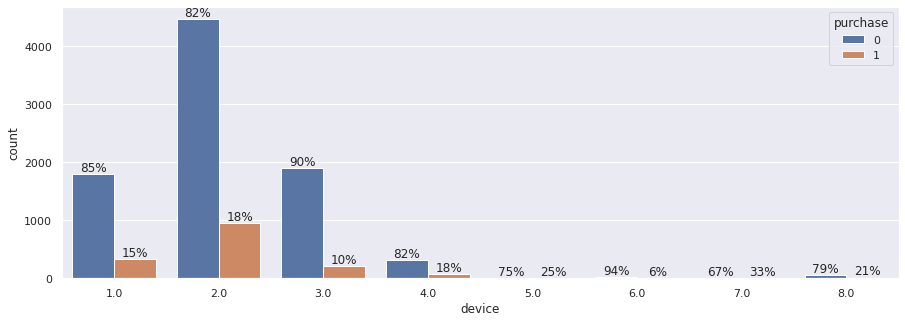

In [314]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x = 'device',hue = 'purchase',data = train_df)
barPerc(train_df, 'device', ax)
plt.show()

In [315]:
device_mean = train_df['device'].mean()
device_median = train_df['device'].median()

print(f'The device mean is: {round(device_mean, 3)}, while the median is: {device_median}')

The device mean is: 2.123, while the median is: 2.0


In [316]:
# lets see the frequent of every value
train_df['device'].value_counts()

The values represented by numbers are irrelevant since this feature describes the device used by the user for the session. We therefore decided to fill in the missing value with the most frequent value. 

Fill all missing values with the most frequent value of each feature

In [317]:
# filling left columns with missing na to most frequent value of every column
train_df = train_df.apply(lambda x:x.fillna(x.value_counts().index[0]))

We see that there are alot of browsers versions, lets see how many browsers types there are 

In [318]:
num_types_internet_browsers = train_df.groupby('internet_browser').size().shape[0]
print(f'We have: {num_types_internet_browsers} different types of internet browsers')

We have: 126 different types of internet browsers


As part of the next phase of this work (relating to categories of features), we will remove the versions and maintain only the type of browser.

We won't care about the browser version since we have many different versions that don't matter to us, so we'll get rid of the versions.

In [319]:
train_df.internet_browser = train_df.internet_browser.apply(lambda x: 'edge' if x[0]=='e' else x)
train_df.internet_browser = train_df.internet_browser.apply(lambda x: 'chrome' if x[0]=='c' else x)
train_df.internet_browser = train_df.internet_browser.apply(lambda x: 'safari' if x[0]=='s' else x)
train_df.internet_browser = train_df.internet_browser.apply(lambda x: x[:10] if x[0]=='b' else x)

In [320]:
train_df.groupby('internet_browser').size().shape[0]

13

Also can be seen- we started with 126 browser types, now we have only 14 of them (and after filling the missing values we will have 13) 

In [321]:
print(f"Finally, we have no missing values in the train_df, right? Answer -> {(train_df.isna().sum() == 0).all()}")

Finally, we have no missing values in the train_df, right? Answer -> True


In [322]:
train_df['Month'].value_counts()

> ####  Feature Engineering

As part of the feature engineering stage, we create a new column for the year season.  
The seasons are defined as spring (March, April, May), summer (June, July, August), fall (September, October, November), and winter (December, January, February).

In [323]:
season_dict = {'Jan': 'Winter',
               'Feb': 'Winter',
               'Mar': 'Spring', 
               'April': 'Spring',
               'May': 'Spring',
               'June': 'Summer',
               'Jul': 'Summer',
               'Aug': 'Summer',
               'Sep': 'Fall',
               'Oct': 'Fall',
               'Nov': 'Fall',
               'Dec': 'Winter'}

train_df['Season'] = train_df['Month'].apply(lambda x: season_dict[x]) # insert the new column

Also as part of the feature engineering stage we will turn the `Weekend` into boolean. 

## Dealing With Outliers

In [324]:
records_num_before_removing_outliers = train_df.shape[0]
print(f'Before removing outliers we have {records_num_before_removing_outliers} records in the train data')

Before removing outliers we have 10425 records in the train data


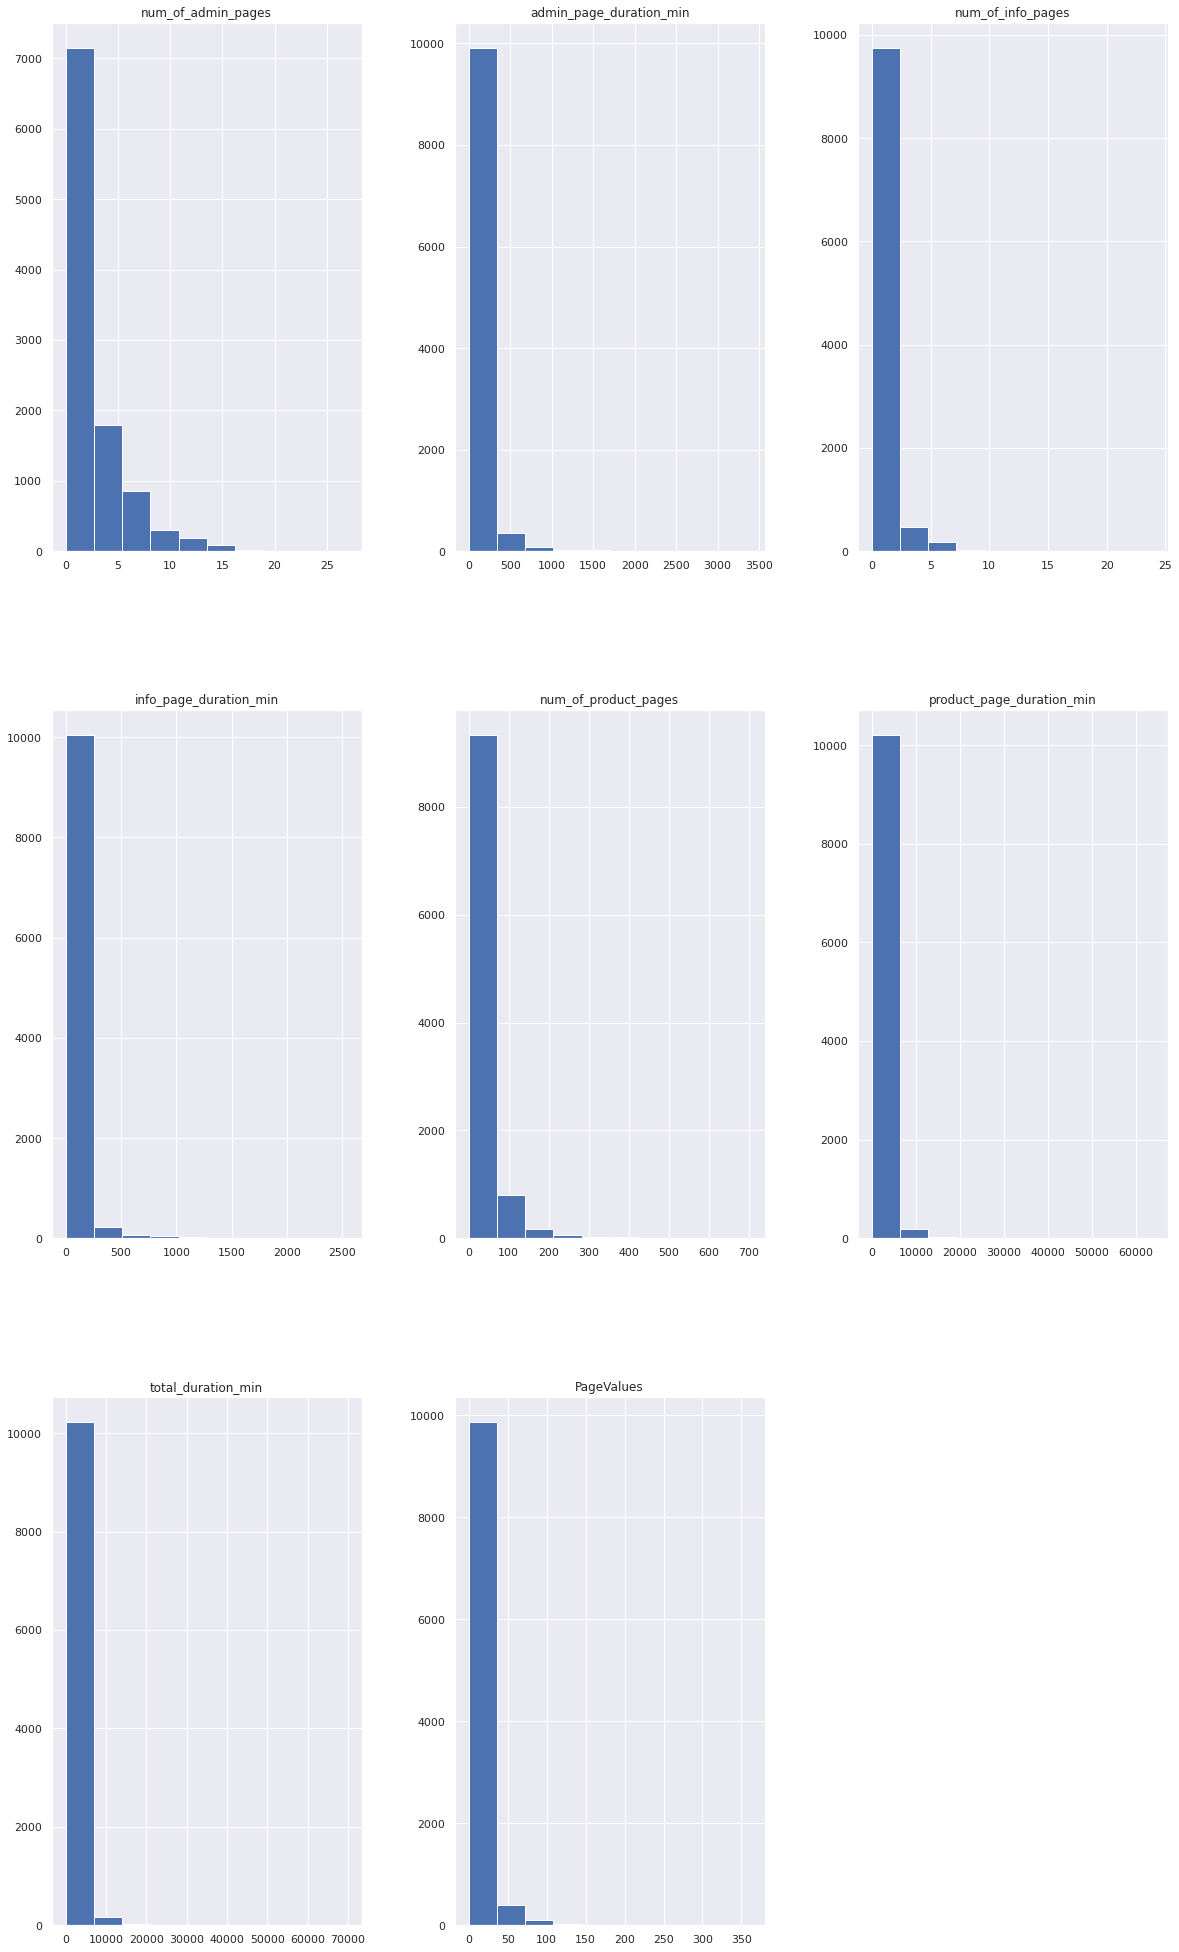

In [325]:
outliers_col_list = ['num_of_admin_pages', 'admin_page_duration_min', 'num_of_info_pages', 'info_page_duration_min',
                     'num_of_product_pages', 'product_page_duration_min', 'total_duration_min', 'PageValues']
train_df[outliers_col_list].hist(figsize= (20,35))
plt.show()

Removing the outliers of each feature

In [326]:
outlier_val_dict = {'num_of_admin_pages':18,
                    'admin_page_duration_min':900,
                    'num_of_info_pages': 7,
                    'info_page_duration_min': 800,
                    'num_of_product_pages': 250,
                    'product_page_duration_min': 10000,
                    'total_duration_min': 12000,
                    'PageValues': 100}

In [327]:
train_df = remove_outlires(train_df, None, outlier_val_dict)

In [328]:
prec_eliminated = round(1-(train_df.shape[0] / records_num_before_removing_outliers), 3) * 100
print(f'Before removing outliers we have {records_num_before_removing_outliers} records in the train data')
print(f'After removing outliers we have {train_df.shape[0]} records in the train data')
print(f'Deleted {prec_eliminated}% of the records')

Before removing outliers we have 10425 records in the train data
After removing outliers we have 10090 records in the train data
Deleted 3.2% of the records


Let's see how it looks now-

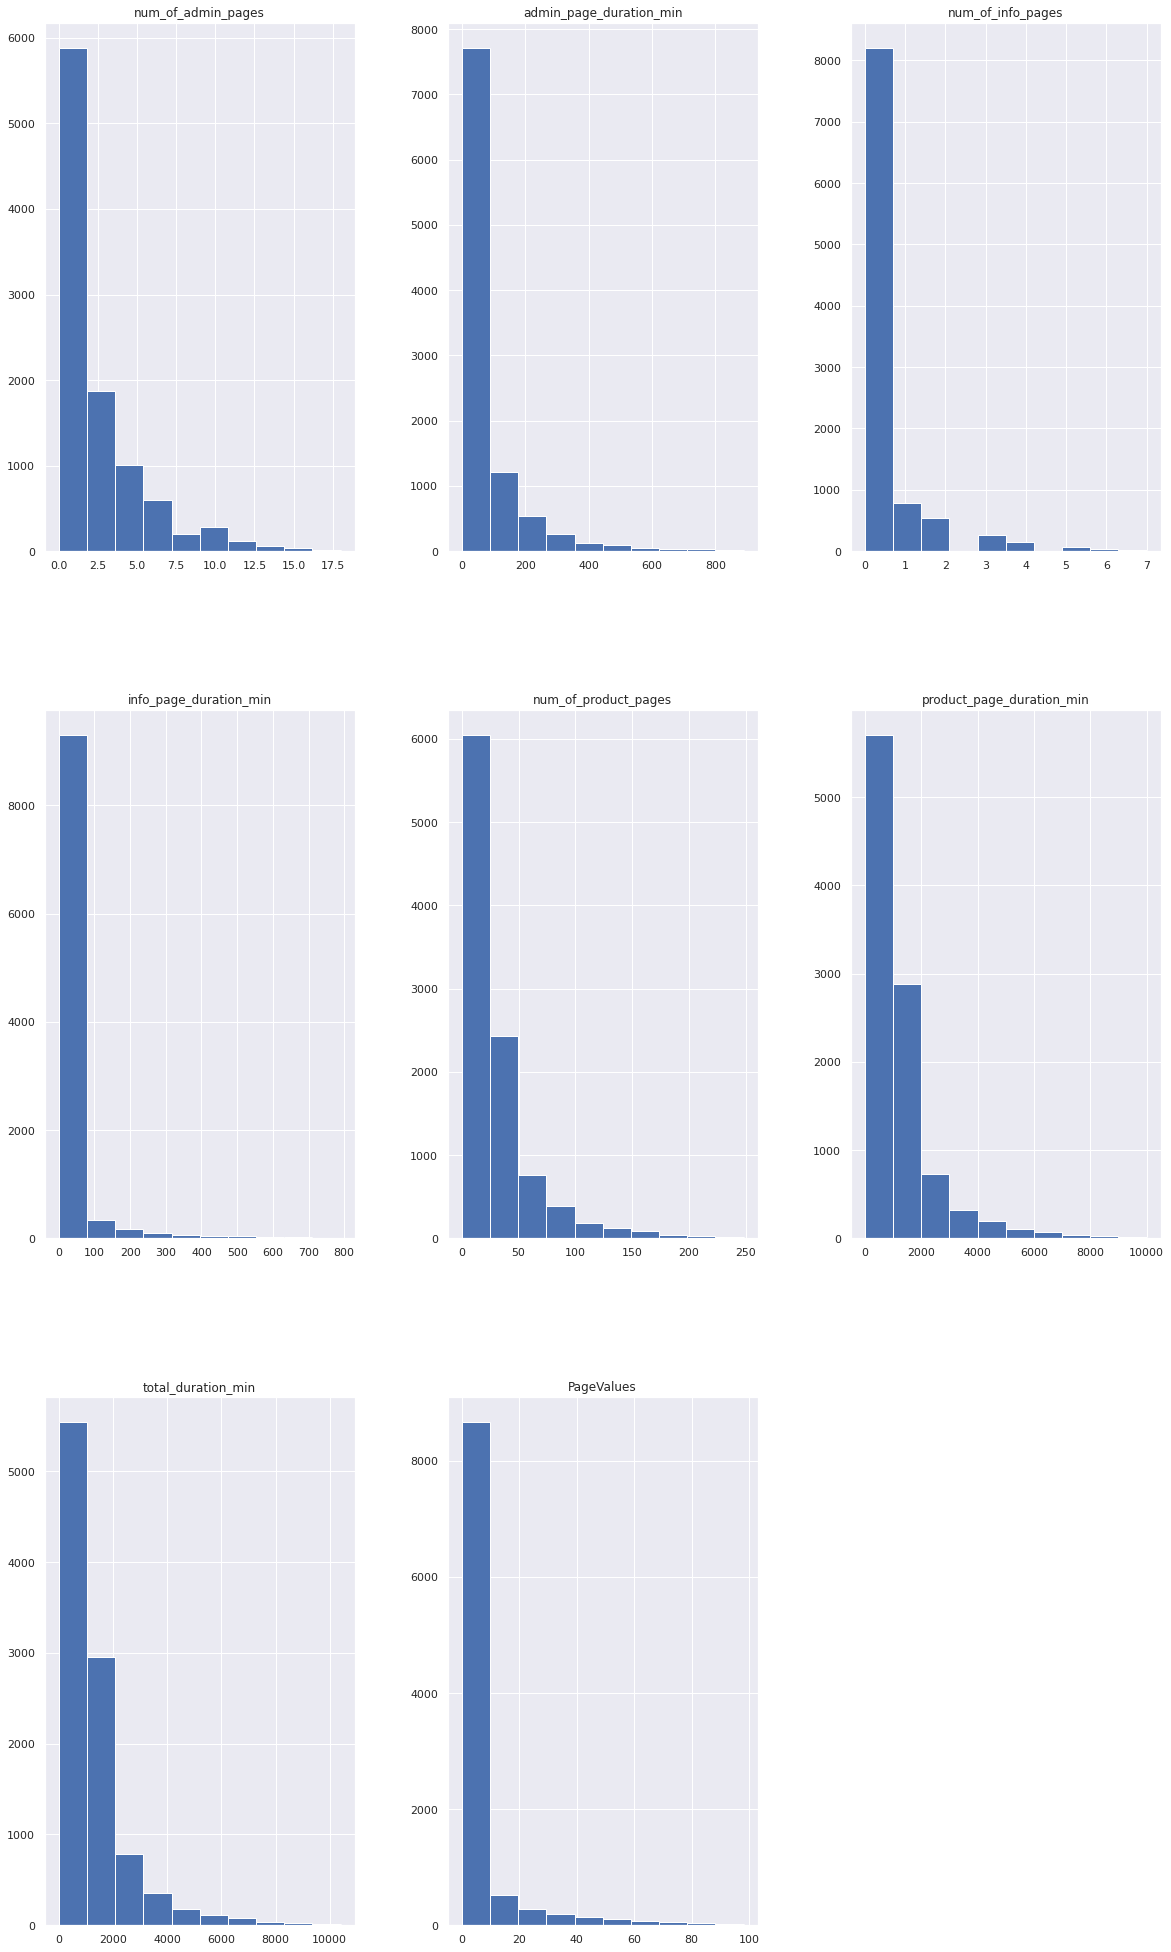

In [329]:
train_df[outliers_col_list].hist(figsize= (20,35))
plt.show()

Detecting outliers using boxplots - relevant to features that distributes normal

In [330]:
# the device feture distribute normal when values lower than 4
# B distribute normal
boxplot_train_df = pd.DataFrame()
boxplot_train_df['device'] = train_df.device[train_df.device<4]
boxplot_train_df['B'] = train_df.B

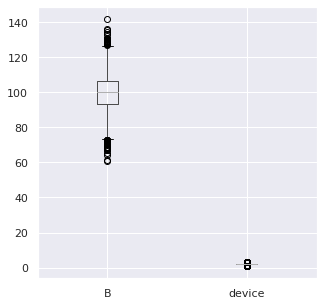

In [331]:
outlierst_columns= ['B','device']
boxplot_train_df.boxplot(outlierst_columns,figsize=(5,5))
plt.show()

Let's see the boxplot from a different angle

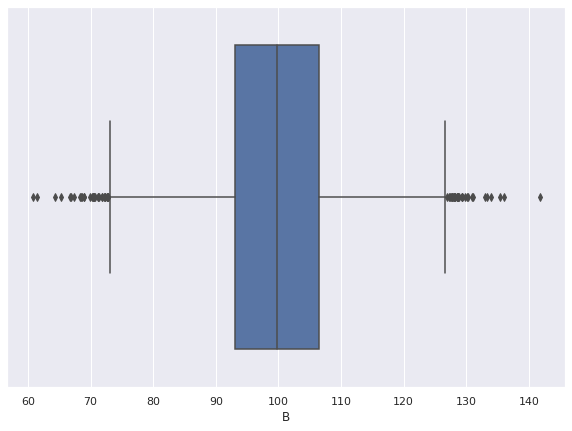

In [332]:
sns.boxplot(boxplot_train_df['device'])
plt.show()

sns.boxplot(boxplot_train_df['B'])
plt.show()

In [333]:
train_df = remove_outlier_iqr(train_df, 'B')
train_df = remove_outlier_iqr(train_df, 'device')

Now the boxplots looks a little different, we removed 159 records. Which are 1.5% of the data at this point. 

## Data Normalization

Although we can see that a number of columns are normalized together with others, the data we have before us, in general, is not quite normalized.

The objective of normalization is to convert numeric columns in a dataset into a common scale without distorting their ranges of values. 
It is required only when features have different ranges, as in our case.

$$\hat X_ik = \frac{X_ik - min(X_k)}{max(X_k) - min(X_k)}$$

#### Column `A`
We considered turning it into a dummy variable, but we saw that it would add 96 columns to the data.

Therefore, we decided to leave this column, and turn the values in it into numerical. There is a possible disadvantage here, as perhaps the numbers have no meaning and the source of the column is in different categories (this is information that is not available to us since we do not know the identity of this column). 

The disadvantage will be reflected in the fact that it will give a different weight to each category. Under the circumstances, this is what we decided to do.

In [334]:
train_df.A.value_counts()

In [335]:
# converting A column to int
train_df['A'] = adjust_col_A(train_df['A'])

In [336]:
# normalize all this columns: values in each column will be between 0 to 1
mmscaler = MinMaxScaler()
columns_to_normalize = ['num_of_admin_pages', 'num_of_info_pages', 'info_page_duration_min', 'admin_page_duration_min',
       'num_of_product_pages', 'product_page_duration_min', 'total_duration_min', 'BounceRates', 'ExitRates',
        'PageValues','closeness_to_holiday', 'B', 'A']
train_df[columns_to_normalize] = mmscaler.fit_transform(train_df[columns_to_normalize])

## Dealing With Categorical Features

In [337]:
# removes _ for relevant records
train_df['internet_browser'] = train_df['internet_browser'].apply(lambda x: x.rstrip('_')) 
train_df['C'] = train_df['C'].apply(lambda x: x.replace('_','')) 

Convert column from numerical to categorical

In [338]:
'''
The func 'get_column_letter()' changes every number to correlated letter. example: 1->A, 2->B, and so on..
The 'Region' and 'device' features are now numerical which relates to categorical variables.
We want to remove that situation, as it results in different weights for different regions and devices.
Using this categorical column, we will later create dummy variables.
'''
train_df['Region'] = train_df['Region'].apply(lambda x: 'Region_' + str(x))
train_df['Region'] = train_df['Region'].apply(lambda x: x[:-2]) 

train_df['device'] = train_df['device'].apply(lambda x: int(x)) #it's string of numbers, convert it to int
train_df['device'] = train_df['device'].apply(lambda x: 'device_' + get_column_letter(x))

> ### As part of the feature engineering, we convert the `Weekend` column boolean (True/False) to 0/1.

In [339]:
train_df['Weekend'] = train_df['Weekend'].apply(lambda x: 1 if x == True else 0)

Get Dummys For The Categorical Columns

In [340]:
catagorical_features = ['device', 'Month', 'Region', 'internet_browser', 'user_type', 'C','Season']
train_df = pd.get_dummies(train_df, prefix='dummy', columns = catagorical_features, drop_first= True)

In [341]:
features_after_adding_dummies = train_df.shape[1]
print(f'Now we have {features_after_adding_dummies} features')

Now we have 58 features


## Dimensionality

#### Let's examine the correlation between features

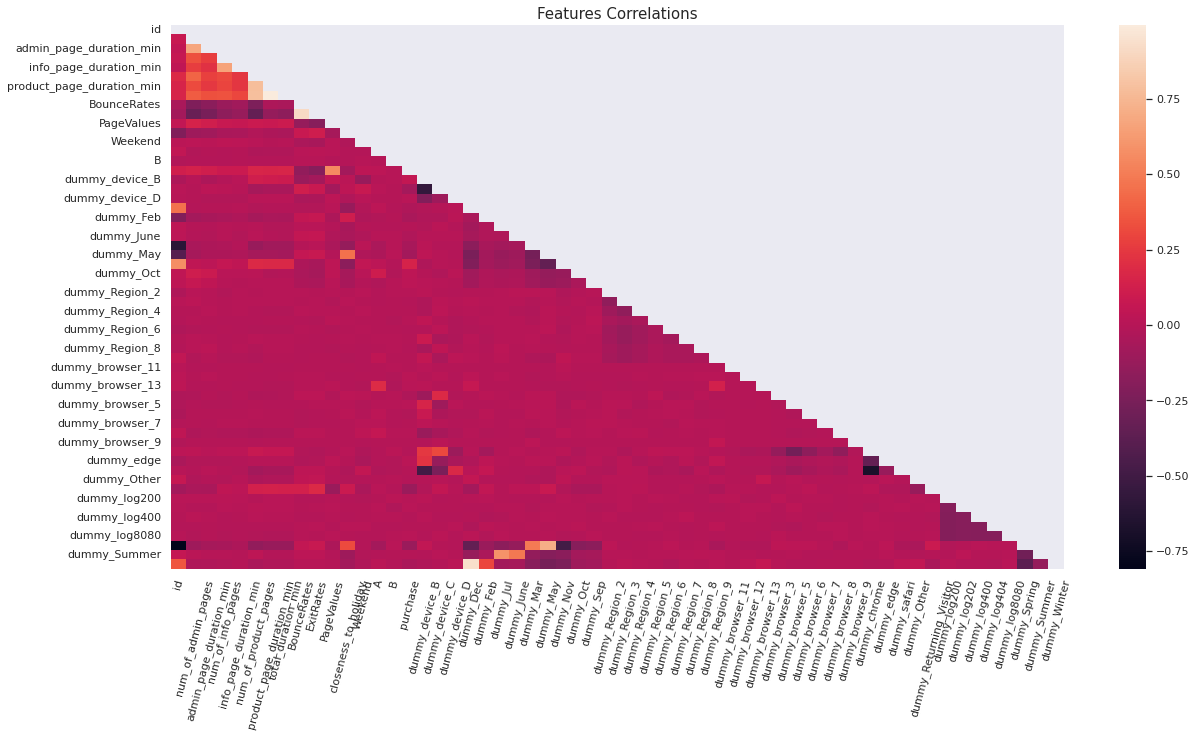

In [342]:
corr_before_dropping = train_df.corr()
plt.figure(figsize = (20,10))
mask_ut = np.triu(np.ones(corr_before_dropping.shape)).astype(np.bool)
hmap = sns.heatmap(corr_before_dropping, mask=mask_ut)
plt.xticks(rotation=75)
plt.title('Features Correlations', fontdict = {'fontsize':15})
plt.show()

In [343]:
corr_t_before_dropping = corr_before_dropping[(abs(corr_before_dropping)>=0.65) & (abs(corr_before_dropping) != 1)].unstack()
corr_t_before_dropping.sort_values(ascending = False).dropna()

### Using Pearsom Correlation

$$P_x,_y = \frac{Cov(X,Y)}{SD(X) * SD(Y)}$$
We found that the results are very similar to the correlations table above, so we decided to base our next steps on the table above. 

In [344]:
stats.pearsonr(train_df.product_page_duration_min, train_df.total_duration_min)

(0.9941283010150433, 0.0)

In [345]:
stats.pearsonr(train_df.admin_page_duration_min, train_df.num_of_admin_pages)

(0.6727675027254338, 0.0)

Since some columns have high correlations, we decided to remove them.

- The number of `num_of_X_pages` correlates with the number of `X_page_duration_min` (which is obviously logical). We thus dropped the `num_of_X_pages` columns (3 columns)
- `total_duration_min` have high correlation to the 3 columns of `X_page_duration_min`
- `BounceRates` and `ExitRates` have high correlation, so we decided to drop one of them. 
- `dummy_safari` and `dummy_chrome` have high correlation, so we decided to drop one of them. 
- `dummy_Dec` and `dummy_Winter` has high correlation, so we decided to drop `dummy_Winter` because `dummy_Dec` gives us more specified information. 
- `dummy_May` and `dummy_Spring` have high correlation, so we decided to drop `dummy_Spring` for the same reason.

A high correlation was found between several columns. Based on this, at first we thought it would be appropriate to lower these columns in order to reduce the dimensions, **but later on after running the models, we realized it would be better to reduce the dimensions with the help of important features.**

In [346]:
# train_df = train_df.drop(['total_duration_min','BounceRates','num_of_product_pages','num_of_info_pages','num_of_admin_pages', 'dummy_safari','dummy_Spring','dummy_Winter'],axis = 1)

## Dimensionality Reduction

- High dimensionality increases the model variance
- Exposure to more noise than signal
- Curse of dimensionality - the space is sparser

In [347]:
train_df.var().sort_values(ascending = False)

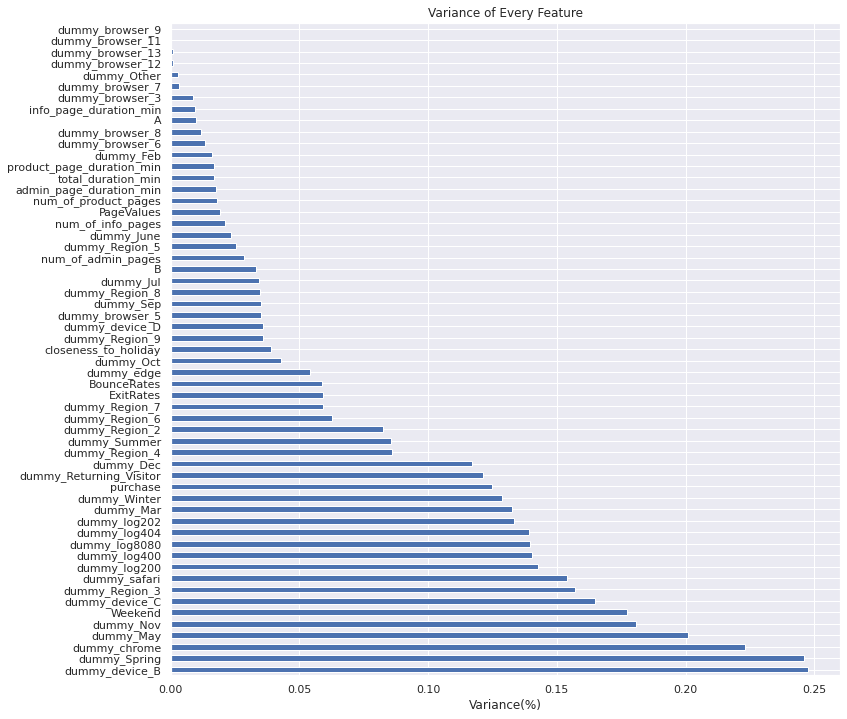

In [348]:
r= train_df.loc[:, train_df.columns != 'id'].var().sort_values(ascending = False)
r.plot.barh(figsize=(12, 12))
plt.title("Variance of Every Feature")
plt.xlabel("Variance(%)")
plt.show()

Based on this graph, we decided what number of features we would like to keep in the data.

In addition, we will later select the features that have the highest correlation for the label, we found that there is a high match between the features that have the highest variance and those we chose to leave based on the correlation.

In [349]:
# leave the only 34 features with the highest correlation to the label
diluted_features = dilute_features(train_df,34)
diluted_features.remove('dummy_browser_12') ## we removed that column becouse thie column not found in the validation. 

Creating some variables we will use in the pipline, test processing and validation processing. 

In [350]:
Y_train = train_df.purchase
X_train = train_df
X_train.drop('purchase', axis = 1, inplace = True)
X_train.shape , Y_train.shape

((9937, 57), (9937,))

In [351]:
X_train = X_train[diluted_features] #keep only the diluted features

In [352]:
X_train.shape

(9937, 33)

# Validation Set Processing

In this stage, we will first split the data into train and validation, and then process the validation set similarly to how we will process the test set. 

We will perform each process on both train and val sets.

In [353]:
train_and_val_data = pd.read_csv('train.csv')

In [354]:
replace_values(train_and_val_data, ["total_duration"], 0, np.nan)
train_and_val_data['info_page_duration'] = train_and_val_data['info_page_duration'].str.replace('minutes', '')
train_and_val_data['product_page_duration'] = train_and_val_data['product_page_duration'].str.replace('minutes', '')
train_and_val_data = train_and_val_data.astype({'product_page_duration' : float}, errors='raise')
train_and_val_data = train_and_val_data.astype({'info_page_duration' : float}, errors='raise')
train_and_val_data.rename(columns = {'admin_page_duration': 'admin_page_duration_min','info_page_duration': 'info_page_duration_min', 'product_page_duration': 'product_page_duration_min',\
                                                    'total_duration': 'total_duration_min'}, inplace = True)
replace_values(train_and_val_data, ["info_page_duration_min", "product_page_duration_min"], 0, np.nan)

In [355]:
find_zeros_and_replace(train_and_val_data, 'admin_page_duration_min', 'num_of_admin_pages')
find_zeros_and_replace(train_and_val_data, 'info_page_duration_min', 'num_of_info_pages')
find_zeros_and_replace(train_and_val_data, 'product_page_duration_min', 'num_of_product_pages')
y_train = train_and_val_data.iloc[:,-1]
train_and_val_data = train_and_val_data.iloc[:,:-1]
train_and_val_data.drop(['D'],axis=1,inplace=True)

In [356]:
# spliting train to - train and validation
train_data, validation_data, train_labels, validation_labels = train_test_split(train_and_val_data, y_train,
                                                        test_size = 0.2,
                                                        random_state= 42, 
                                                        shuffle=True)

In [357]:
print('Train Dimensions:')
print(f'        data: {train_data.shape}')
print(f'        labels: {train_labels.shape}')

print('\nValidation Dimensions:')
print(f'        data: {validation_data.shape}')
print(f'        labels: {validation_labels.shape}')

Train Dimensions:
        data: (8383, 21)
        labels: (8383,)

Validation Dimensions:
        data: (2096, 21)
        labels: (2096,)


In [358]:
# train_data process
train_data, train_labels = remove_records_with_many_nans_VAL(train_data, train_labels, 5)
columns_list = ['num_of_admin_pages', 'admin_page_duration_min', 'num_of_product_pages', 'product_page_duration_min']
for col in columns_list:
    train_data[col].fillna(value = train_data[col].mean(axis = 0, skipna = True), inplace = True)
replace_values(train_data, ['info_page_duration_min'], np.nan, 0)
train_data['closeness_to_holiday'].fillna(value = train_data.closeness_to_holiday.mean(axis = 0, skipna = True), inplace=True)
most_frequent_val_col_device = train_data.device.value_counts().index[0]
most_frequent_val_col_A = train_data.A.value_counts().index[0]
train_data = train_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
train_data.A = adjust_col_A(train_data.A)
train_data.internet_browser = train_data.internet_browser.apply(lambda x: 'edge' if x[0]=='e' else x)
train_data.internet_browser = train_data.internet_browser.apply(lambda x: 'chrome' if x[0]=='c' else x)
train_data.internet_browser = train_data.internet_browser.apply(lambda x: 'safari' if x[0]=='s' else x)
train_data.internet_browser = train_data.internet_browser.apply(lambda x: x[:10] if x[0]=='b' else x)
train_data['Season'] = train_data['Month'].apply(lambda x: season_dict[x]) # insert the new column
train_data, train_labels = remove_outlires(train_data, train_labels, outlier_val_dict)
train_data[columns_to_normalize] = mmscaler.fit_transform(train_data[columns_to_normalize]) 
# removes _ for relevant records
train_data['internet_browser'] = train_data['internet_browser'].apply(lambda x: x.rstrip('_')) 
train_data['C'] = train_data['C'].apply(lambda x: x.replace('_','')) 
train_data['Region'] = train_data['Region'].apply(lambda x: 'Region_' + str(x))
train_data['Region'] = train_data['Region'].apply(lambda x: x[:-2]) 
train_data['device'] = train_data['device'].apply(lambda x: int(x)) #it's string of numbers, convert it to int
train_data['device'] = train_data['device'].apply(lambda x: 'device_' + get_column_letter(x))
train_data['Weekend'] = train_data['Weekend'].apply(lambda x: 1 if x == True else 0)

In [359]:
# validation_data process
# Fill the columns in 'columns_list' with the mean of the same columns in train_data
for col in columns_list: 
    validation_data[col].fillna(value = train_data[col].mean(axis = 0, skipna = True), inplace = True)
replace_values(validation_data, ['info_page_duration_min'], np.nan, 0)
validation_data['closeness_to_holiday'].fillna(value = train_data.closeness_to_holiday.mean(axis = 0, skipna = True), inplace=True)
validation_data['device'] = validation_data['device'].replace(np.nan, most_frequent_val_col_device) 
validation_data['A'].replace(np.nan, most_frequent_val_col_A, inplace = True)
# filling the columns left with missing na to most frequent value of every column - get the most frequent value from the train data
fill_nan_with_most_frequent_value(train_data, validation_data)
validation_data.internet_browser = validation_data.internet_browser.apply(lambda x: 'edge' if x[0]=='e' else x)
validation_data.internet_browser = validation_data.internet_browser.apply(lambda x: 'chrome' if x[0]=='c' else x)
validation_data.internet_browser = validation_data.internet_browser.apply(lambda x: 'safari' if x[0]=='s' else x)
validation_data.internet_browser = validation_data.internet_browser.apply(lambda x: x[:10] if x[0]=='b' else x)
validation_data['Season'] = validation_data['Month'].apply(lambda x: season_dict[x]) # insert the new column
validation_data['A'] = adjust_col_A(validation_data['A'])
validation_data[columns_to_normalize] = mmscaler.fit_transform(validation_data[columns_to_normalize])
# removes _ for relevant records
validation_data['internet_browser'] = validation_data['internet_browser'].apply(lambda x: x.rstrip('_')) 
validation_data['C'] = validation_data['C'].apply(lambda x: x.replace('_','')) 
validation_data['device'] = validation_data['device'].apply(lambda x: int(x) if x != np.nan else x) #it's string of numbers, convert it to int
validation_data['device'] = validation_data['device'].apply(lambda x: 'device_' + get_column_letter(x))
train_data['Region'] = train_data['Region'].apply(lambda x: 'Region_' + str(x))
train_data['Region'] = train_data['Region'].apply(lambda x: x[:-2]) 
validation_data['Weekend'] = validation_data['Weekend'].apply(lambda x: 1 if x == True else 0)

In [360]:
train_data.shape, validation_data.shape

((8066, 22), (2096, 22))

In [361]:
# Now let's get dummies 
train_data = pd.get_dummies(train_data, prefix='dummy', columns = catagorical_features, drop_first= True) 
validation_data = pd.get_dummies(validation_data, prefix='dummy', columns = catagorical_features, drop_first= True)

In [362]:
train_data.shape, validation_data.shape

((8066, 53), (2096, 61))

In [363]:
# keep the only the diluted features
train_data = train_data[diluted_features]
validation_data = validation_data[diluted_features]

In [364]:
# # Drop columns - so that both data sets contain the same columns.
# # During the 'Models' phase of the project, we will compare the performance of the train and validation with all
# #                                                    the features versus the train and validation after dimentonality reduction.
# train_data_with_all_features.drop(['dummy_device_G', 'dummy_browser_12'], axis = 1,inplace= True)
# # val_data_with_all_features.drop('dummy_browser_9',axis = 1,inplace=True)

In [365]:
print('Train Data Shape:')
print(f'        data: {train_data.shape}')
print('\nValidation Data Shape:')
print(f'        data: {validation_data.shape}')

Train Data Shape:
        data: (8066, 33)

Validation Data Shape:
        data: (2096, 33)


# Test Processing

As we have noted, the records we removed from the training set (using two functions - one lowers values of rows with many missing values and the other lowers values of rows with extreme values) - we did not perform on a validation set and also on the test set. 

In [366]:
# load the test data
test_df = pd.read_csv('test.csv')

Cleaning the data - same as we did for the train data

In [367]:
test_df.drop(['D'],axis=1,inplace=True) # most of this coilumn's values are missing- same as train data
test_df["total_duration"] = test_df["total_duration"].replace({0:np.nan})
#erase the 'minutes' in those 2 columns + change the number from str to float
test_df['info_page_duration'] = test_df['info_page_duration'].str.replace('minutes', '')
test_df['product_page_duration'] = test_df['product_page_duration'].str.replace('minutes', '')
test_df = test_df.astype({'product_page_duration' : float}, errors='raise')
test_df = test_df.astype({'info_page_duration' : float}, errors='raise')
# add the unit of time to the columns names
test_df.rename(columns = {'admin_page_duration': 'admin_page_duration_min','info_page_duration': 'info_page_duration_min', 'product_page_duration': 'product_page_duration_min',\
                                                    'total_duration': 'total_duration_min'}, inplace = True)
# replacing 0 with nan
test_df["info_page_duration_min"] = test_df["info_page_duration_min"].replace({0:np.nan})
test_df["product_page_duration_min"] = test_df["product_page_duration_min"].replace({0:np.nan})

Outliers & Filling Missing Values

In [368]:
find_zeros_and_replace(test_df, 'admin_page_duration_min', 'num_of_admin_pages')
find_zeros_and_replace(test_df, 'info_page_duration_min', 'num_of_info_pages')
find_zeros_and_replace(test_df, 'product_page_duration_min', 'num_of_product_pages')

In order to fill in the missing values in the test data, we will use the `train_data_for_test_preprocessing` (which is a copy of the train data). 
As we don't want to learn from the test data, it would be a mistake to fill the missing values based on the test data. 

In [369]:
most_frequent_val_col_A_from_train_and_val = train_and_val_data.A.value_counts().index[0]
most_frequent_val_col_device_from_train_and_val = train_and_val_data.device.value_counts().index[0]

In [370]:
test_df.isna().sum()

In [371]:
columns_list = ['num_of_admin_pages', 'admin_page_duration_min', 'num_of_product_pages', 'product_page_duration_min']
for col in columns_list:
    test_df[col].fillna(value = train_df[col].mean(axis = 0, skipna = True), inplace = True)
replace_values(test_df, ['info_page_duration_min'], np.nan, 0)
test_df['closeness_to_holiday'].fillna(value = train_df.closeness_to_holiday.mean(axis = 0, skipna = True), inplace=True)
test_df['device'] = test_df['device'].replace(np.nan, most_frequent_val_col_device_from_train_and_val) 
test_df['A'].replace(np.nan, most_frequent_val_col_A_from_train_and_val, inplace = True)
# filling the columns left with missing na to most frequent value of every column - get the most frequent value from the train data
fill_nan_with_most_frequent_value(train_and_val_data, test_df)
test_df.internet_browser = test_df.internet_browser.apply(lambda x: 'edge' if x[0]=='e' else x)
test_df.internet_browser = test_df.internet_browser.apply(lambda x: 'chrome' if x[0]=='c' else x)
test_df.internet_browser = test_df.internet_browser.apply(lambda x: 'safari' if x[0]=='s' else x)
test_df.internet_browser = test_df.internet_browser.apply(lambda x: x[:10] if x[0]=='b' else x)
test_df['Season'] = test_df['Month'].apply(lambda x: season_dict[x]) # insert the new column
test_df['A'] = adjust_col_A(test_df['A'])
test_df[columns_to_normalize] = mmscaler.fit_transform(test_df[columns_to_normalize])
# removes _ for relevant records
test_df['internet_browser'] = test_df['internet_browser'].apply(lambda x: x.rstrip('_')) 
test_df['C'] = test_df['C'].apply(lambda x: x.replace('_','')) 
test_df['device'] = test_df['device'].apply(lambda x: int(x) if x != np.nan else x) #it's string of numbers, convert it to int
test_df['device'] = test_df['device'].apply(lambda x: 'device_' + get_column_letter(x))
# test_df['Region'] = test_df['Region'].apply(lambda x: 'Region_' + get_column_letter(x))
test_df['Region'] = test_df['Region'].apply(lambda x: 'Region_' + str(x))
test_df['Region'] = test_df['Region'].apply(lambda x: x[:-2])
test_df['Weekend'] = test_df['Weekend'].apply(lambda x: 1 if x == True else 0)
# Now let's get dummies 
test_df = pd.get_dummies(test_df, prefix='dummy', columns = catagorical_features, drop_first= True) 
test_df = test_df[diluted_features]

In [372]:
print(f'Now we do not have missing values in the test data.. right? Answer-> {(test_df.isna().sum() == 0).all()}')

Now we do not have missing values in the test data.. right? Answer-> True


In [373]:
sorted(list(test_df.columns)) == sorted(list(X_train.columns)) # same fatures in train and test set

True

#### Dimensionality Reduction

In contrast to the processing of the data on the training, here at the stage of lowering the dimensions and feature selection of course we did not make a selection of the features according to the correlation to the label, we chose the same features that we chose in the training data set.

# Models

First, let's split the train data into train and validation ***************

In [374]:
print('Train Dimensions:')
print(f'        data: {train_data.shape}')
print(f'        labels: {train_labels.shape}')

print('\nValidation Dimensions:')
print(f'        data: {validation_data.shape}')
print(f'        labels: {validation_labels.shape}')

Train Dimensions:
        data: (8066, 33)
        labels: (8066,)

Validation Dimensions:
        data: (2096, 33)
        labels: (2096,)


### 1. KNN

Model : KNeighborsClassifier()
Best Params: {'n_neighbors': 300} 

Train AUC: 0.5979847100264625
K-fold Cross Validation TRAIN Accuracy Mean: 83.28 %
Train accuracy: 85.27 %
Train Standard Deviation: 0.86 %
Train Mse: 14.73 %

Validation AUC: 0.5737155098847959
K-fold Cross Validation VALIDATION Accuracy Mean: 82.97 %
Val accuracy: 84.92 %
Val Standard Deviation: 1.50 %
Val Mse: 15.08 %



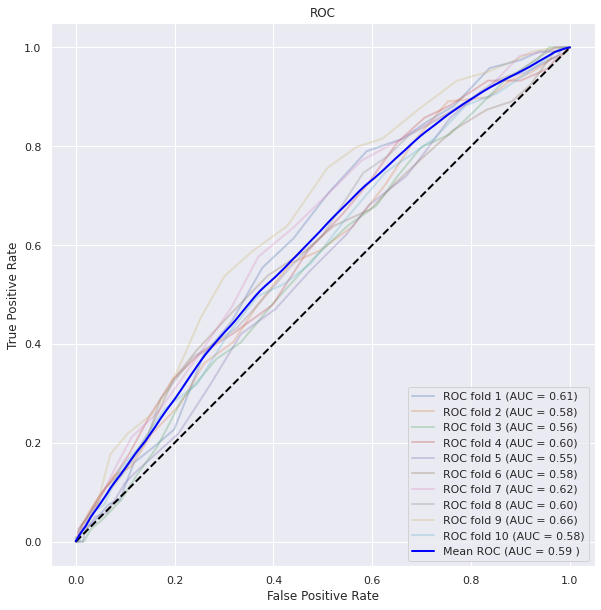

In [375]:
# run_model(model, parameters, train_data, validation_data, train_labels, validation_labels)
KNN_parameters = {'n_neighbors' : [295, 300, 305]}

run_model(KNeighborsClassifier(), KNN_parameters, train_data, validation_data, train_labels, validation_labels)
plot_KFold(KNeighborsClassifier(n_neighbors = 83), train_data, train_labels, 10)

### 2. Logistic Regression

Model : LogisticRegression()
Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'} 

Train AUC: 0.8990539632402322
K-fold Cross Validation TRAIN Accuracy Mean: 87.09 %
Train accuracy: 88.76 %
Train Standard Deviation: 1.52 %
Train Mse: 11.24 %

Validation AUC: 0.8711100839140948
K-fold Cross Validation VALIDATION Accuracy Mean: 86.40 %
Val accuracy: 87.26 %
Val Standard Deviation: 1.43 %
Val Mse: 12.74 %



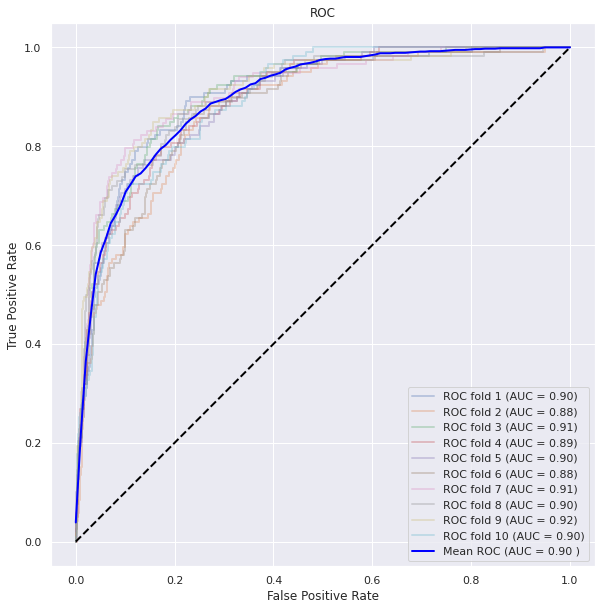

In [376]:
LogisticRegression_parameters = {'penalty' : ['l1', 'l2'], 'solver':['liblinear'], 'C' : [10**p for p in range(-10,0)]}
run_model(LogisticRegression(), LogisticRegression_parameters, train_data, validation_data, train_labels, validation_labels)
plot_KFold(LogisticRegression(C = 0.1, penalty = 'l1', solver = 'liblinear'), train_data, train_labels, 10)

### 3. Decision Tree

Model : DecisionTreeClassifier()
Best Params: {'criterion': 'gini', 'max_depth': 5, 'random_state': 0} 

Train AUC: 0.9230969245930234
K-fold Cross Validation TRAIN Accuracy Mean: 86.45 %
Train accuracy: 91.5 %
Train Standard Deviation: 0.92 %
Train Mse: 8.50 %

Validation AUC: 0.9117061939980087
K-fold Cross Validation VALIDATION Accuracy Mean: 85.45 %
Val accuracy: 89.27 %
Val Standard Deviation: 1.24 %
Val Mse: 10.73 %



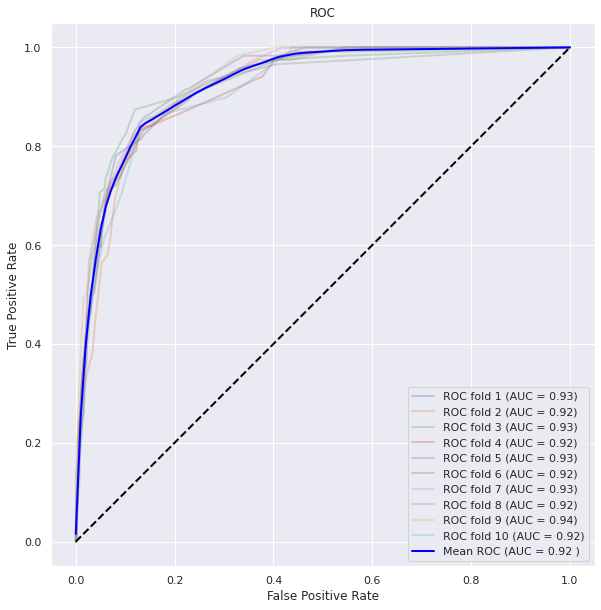

In [377]:
res = tree.DecisionTreeClassifier()
DecisionTreeClassifier_paramters = {'criterion' : ['entropy','gini'],'max_depth':range(3, 7, 2), 'random_state': [0]}

run_model(tree.DecisionTreeClassifier(), DecisionTreeClassifier_paramters, train_data, validation_data, train_labels, validation_labels)
plot_KFold(tree.DecisionTreeClassifier(criterion = 'gini',max_depth = 5, random_state = 0), train_data, train_labels, 10)

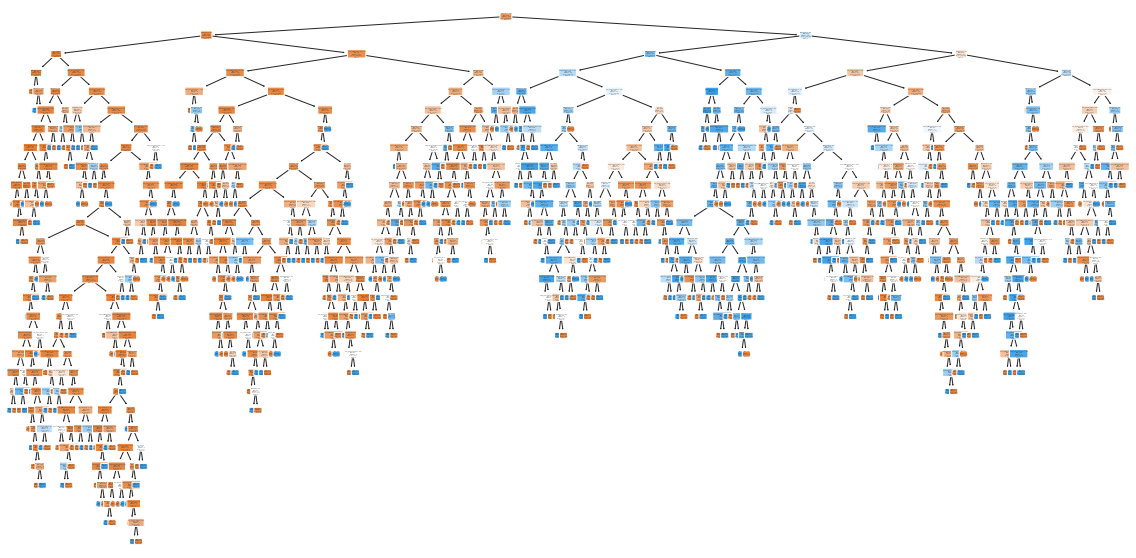

In [378]:
# cool graph!
res.fit(train_data, train_labels)
plt.figure(figsize=(20,10))
dot_data  = plot_tree(res, 
                    feature_names = train_data.columns,
                    class_names = ["0","1"],
                    rounded = True, proportion = False, impurity = True,
                    label='all', precision = 2, filled = True) 

### 4. Random Forest

Model : RandomForestClassifier()
Best Params: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 194, 'random_state': 1} 

Train AUC: 0.9356574880084505
K-fold Cross Validation TRAIN Accuracy Mean: 90.70 %
Train accuracy: 94.71 %
Train Standard Deviation: 0.93 %
Train Mse: 5.29 %

Validation AUC: 0.9255884653676575
K-fold Cross Validation VALIDATION Accuracy Mean: 90.31 %
Val accuracy: 90.03 %
Val Standard Deviation: 1.57 %
Val Mse: 9.97 %



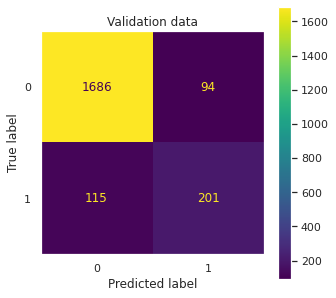

In [379]:
RandomForestClassifier_parameters = {'n_estimators' : [193, 194, 195] ,'max_depth':[10, 11, 12],
                                    'criterion':['entropy','gini'],'min_samples_leaf':[2, 3, 4],
                                    'min_samples_split':[1, 2, 3],'random_state' : [1]}
run_model(RandomForestClassifier(), RandomForestClassifier_parameters, train_data, validation_data, train_labels, validation_labels)

This is the selected model, **now let's run it with the best parameters found**

Model : RandomForestClassifier()
Best Params: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 194, 'random_state': 0} 

Train AUC: 0.934484902918804
K-fold Cross Validation TRAIN Accuracy Mean: 90.64 %
Train accuracy: 94.59 %
Train Standard Deviation: 0.87 %
Train Mse: 5.41 %

Validation AUC: 0.9261111506186886
K-fold Cross Validation VALIDATION Accuracy Mean: 89.88 %
Val accuracy: 90.31 %
Val Standard Deviation: 1.43 %
Val Mse: 9.69 %



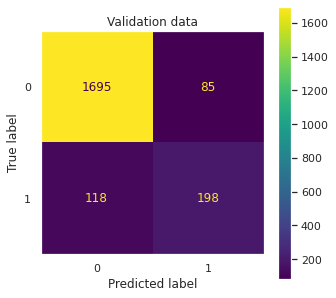

In [380]:
RFC_best_parameters = {'criterion' : ['entropy'], 'max_depth' : [11], 'min_samples_leaf' : [3], 
                                        'min_samples_split' : [2], 'n_estimators' : [194], 'random_state' : [0]}

run_model(RandomForestClassifier(), RFC_best_parameters, train_data, validation_data, train_labels, validation_labels)

#### Analyzing the confusion matrix

By using the matrix of confusion, a number of metrics can be derived that can be used to evaluate the model. These metrics include accuracy, precision, sensitivity, and specificity.
The sensitivity-specificity tradeoff is of course a difficult one, and below we have presented the ROC curves and AUC metrics that gave the model one score. Essentially, this metric takes into account all the metrics mentioned above and gives the model a score.

From the cells in the matrix we learn-

> (1,1) - TP - The number of sessions that ended with a purchase, and the model classified them as such.

> (0,0) - TN- The number of sessions that did not end with a purchase, and we labeled them as those that will not end with a purchase.

> (0,1) - FN - The number of sessions which were incorrectly predicted and didn't result in a purchase, i.e. the model predicted that they would end in a purchase.

> (1,0) - FP- The number of sessions where our forecast was wrong, but they ended in a purchase, i.e. the model predicted that these sessions would not end in a purchase.

From the fact that FP is higher than FN it can be learned that the model is strong in its specificity, which causes the FPR  measure to be minimized.

$$Specificity = \frac{TN}{TN + FP}$$



$$FPR = 1- \frac{FP}{TN + FP}$$

We conclude that this model is the best one we have found based on its confusion matrix in comparison to other confusion matrices we have found in other models.

#### Feature Importance

At this point we want to examine what are the best features. 

We will test this based on the data of the entire train data, with the alternative being to test this on the training data after the division into a validation set. 

We decided to do this in order to make a decision based on more data, which would give us greater certainty.

In [381]:
X_train[diluted_features].shape , Y_train.shape

((9937, 33), (9937,))

In [382]:
X_train_dropped_id = X_train[diluted_features].copy() # we do not want this column to be calculated
X_train_dropped_id.drop(('id'), axis = 1, inplace = True) 

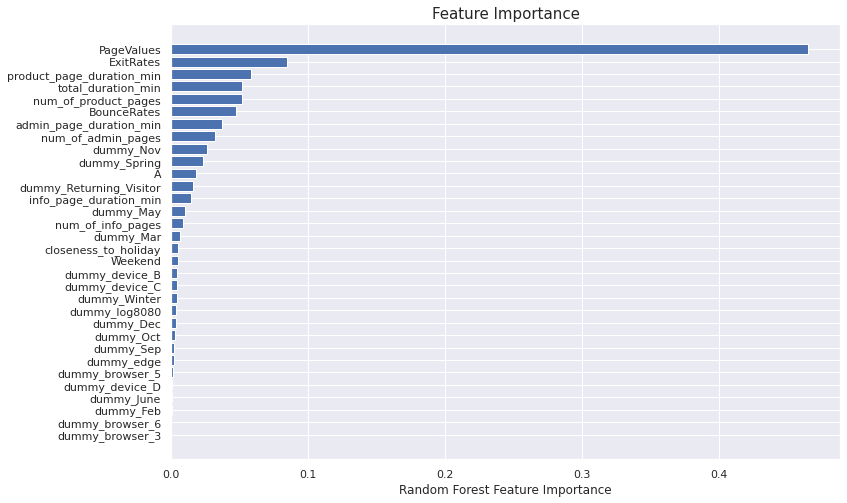

In [383]:
# Check for th entire train data (not splitted into train and validation so we have more data to be based on)
clf = RandomForestClassifier(criterion= 'entropy', max_depth = 11, n_estimators = 194, random_state = 0, min_samples_split = 2,
                                        min_samples_leaf = 3) #using the best parameters we found      
clf.fit(X_train_dropped_id, Y_train)

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 10})

sorted_idx = clf.feature_importances_.argsort()
plt.barh(X_train_dropped_id.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("Feature Importance", fontsize = 15)
plt.show()

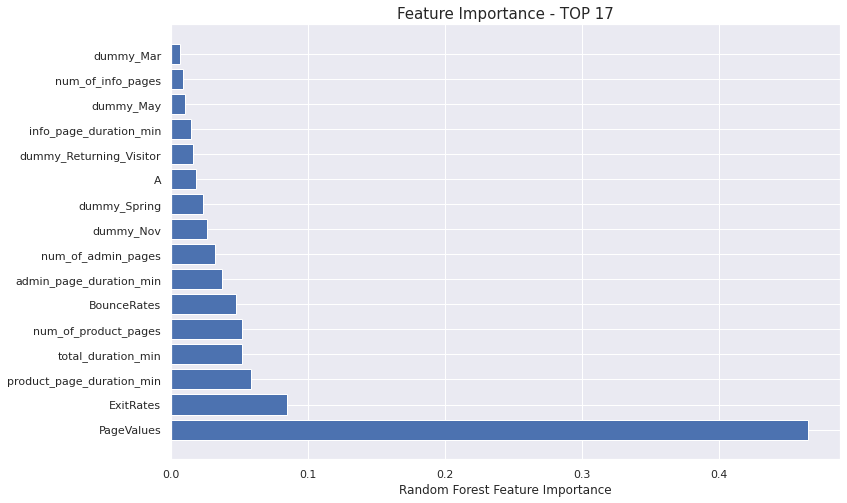

In [384]:
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 10})

sorted_idx = clf.feature_importances_.argsort()
sorted_idx = sorted_idx[-1:-17:-1]
plt.barh(X_train_dropped_id.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("Feature Importance - TOP 17", fontsize = 15)
plt.show()
top_17_feature_imortance = X_train_dropped_id.columns[sorted_idx]

As we can see, the most important feature (by far!) is`PageValue`

In [385]:
top_17_feature_imortance = top_17_feature_imortance.insert(0,'id')
# train_data_10_features = train_data[top_10_feature_imortance]
train_data_17_features = train_data[top_17_feature_imortance]
# val_data_10_features = validation_data[top_10_feature_imortance]
val_data_17_features = validation_data[top_17_feature_imortance]

##### 17 Features

Model : RandomForestClassifier()
Best Params: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 194, 'random_state': 0} 

Train AUC: 0.9364628233250644
K-fold Cross Validation TRAIN Accuracy Mean: 90.76 %
Train accuracy: 95.2 %
Train Standard Deviation: 0.93 %
Train Mse: 4.80 %

Validation AUC: 0.9289023609728346
K-fold Cross Validation VALIDATION Accuracy Mean: 89.93 %
Val accuracy: 90.08 %
Val Standard Deviation: 1.24 %
Val Mse: 9.92 %



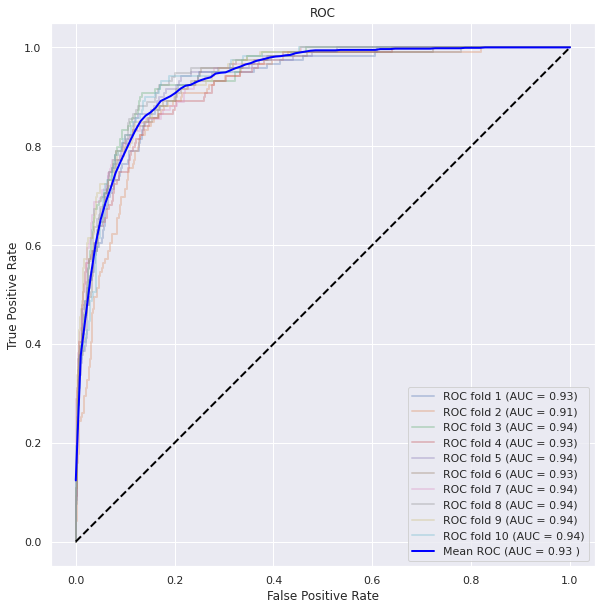

In [386]:
RFC_best_parameters = {'criterion' : ['entropy'], 'max_depth' : [11], 'min_samples_leaf' : [3], 
                                        'min_samples_split' : [2], 'n_estimators' : [194], 'random_state' : [0]}
        
run_model(RandomForestClassifier(), RFC_best_parameters, train_data_17_features, val_data_17_features,
                                                                                               train_labels, validation_labels)

plot_KFold(RandomForestClassifier(criterion = 'entropy', max_depth= 10, min_samples_leaf=3, 
                            min_samples_split=2, n_estimators=193, random_state=0), train_data, train_labels, 10)

## Model Evaluation

We want to later run the model with the most important features. 
We will do this once with 17 features, and a second time on 10 features. The features are selected based on the graphs shown above.
And after running several times, we discovered that the 17 most important features lead to the best model so we chose it.

### Overfitting

If the model performs better on the training set than on the test set, it means that the model is likely overfitting.
By examining the above models `accuracy` and `MSE` values we can see only slight defferences.

### Analyzing the confusion matrix
> Appears above after the matrix is displayed.

# Pipeline

In [387]:
# load the data
X_test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
# Definition of a number of variables in favor of the use of functions.
# Some of these variables are outputs of functions called during the flow of the notebook
mmscaler = MinMaxScaler()
columns_to_normalize = ['num_of_admin_pages', 'num_of_info_pages', 'info_page_duration_min', 'admin_page_duration_min',
       'num_of_product_pages', 'product_page_duration_min', 'total_duration_min', 'BounceRates', 'ExitRates',
        'PageValues','closeness_to_holiday', 'B', 'A']

season_dict = {'Jan': 'Winter',
               'Feb': 'Winter',
               'Mar': 'Spring', 
               'April': 'Spring',
               'May': 'Spring',
               'June': 'Summer',
               'Jul': 'Summer',
               'Aug': 'Summer',
               'Sep': 'Fall',
               'Oct': 'Fall',
               'Nov': 'Fall',
               'Dec': 'Winter'}

outlier_val_dict = {'num_of_admin_pages':18,
                    'admin_page_duration_min':900,
                    'num_of_info_pages': 7,
                    'info_page_duration_min': 800,
                    'num_of_product_pages': 250,
                    'product_page_duration_min': 10000,
                    'total_duration_min': 12000,
                    'PageValues': 100}

columns_list = ['num_of_admin_pages', 'admin_page_duration_min', 'num_of_product_pages', 'product_page_duration_min']

catagorical_features = ['device', 'Month', 'Region', 'internet_browser', 'user_type', 'C','Season']
top_17_feature_imortance = ['id', 'PageValues', 'ExitRates', 'product_page_duration_min',
       'num_of_product_pages', 'total_duration_min', 'BounceRates',
       'admin_page_duration_min', 'num_of_admin_pages', 'dummy_Nov',
       'dummy_Spring', 'dummy_Returning_Visitor', 'A',
       'info_page_duration_min', 'dummy_May', 'num_of_info_pages',
       'dummy_Mar']
# prediction file
final_prediction_to_submit = Pipeline(train, X_test, top_17_feature_imortance)
final_prediction_to_submit.to_csv('Submission_group_32.csv') # save as csv
final_prediction_to_submit # as data frame

,predict_prob
id,
0,0.012514
1,0.024288
2,0.102114
3,0.022732
4,0.007475
...,...
1846,0.069799
1847,0.040623
1848,0.050880
